<a href="https://colab.research.google.com/github/utkarsh9630/AI4Invest-Collab/blob/main/TTS_Emotion_Aware_Team5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text to Speech

In [ ]:
!pip install -q tensorboard

In [ ]:
!pip install -q pandas

In [ ]:
import os
import re
import math
import random

import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import matplotlib.pyplot as plt

In [ ]:
!pip install -q kagglehub

In [ ]:

import kagglehub

# Download latest version
path_lj = kagglehub.dataset_download("mathurinache/the-lj-speech-dataset")

print("Path to dataset files:", path_lj)

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /root/.cache/kagglehub/datasets/mathurinache/the-lj-speech-dataset/versions/1


In [ ]:
import os
os.listdir(path_lj)

['LJSpeech-1.1']

In [ ]:
import kagglehub

# Download latest version
path_esd = kagglehub.dataset_download("nguyenthanhlim/emotional-speech-dataset-esd")

print("Path to dataset files:", path_esd)

Path to dataset files: /root/.cache/kagglehub/datasets/nguyenthanhlim/emotional-speech-dataset-esd/versions/1


In [ ]:
os.listdir(path_esd)

['Emotion Speech Dataset']

In [ ]:
import os
import re
import pandas as pd

ESD_RAW_DIR = path_esd + "/Emotion Speech Dataset"
LJS_RAW_DIR = path_lj + "/LJSpeech-1.1"


OUTPUT_DIR = "./processed_metadata"
os.makedirs(OUTPUT_DIR, exist_ok=True)

ESD_OUTPUT_CSV = os.path.join(OUTPUT_DIR, "esd_clean.csv")
LJS_OUTPUT_CSV = os.path.join(OUTPUT_DIR, "ljs_clean.csv")
COMBINED_OUTPUT_CSV = os.path.join(OUTPUT_DIR, "esd_ljs_combined.csv")

# Constants
EMOTION_WORDS = ["neutral", "angry", "happy", "sad", "surprise"]
EMOTION_MAP = {emo:i for i,emo in enumerate(EMOTION_WORDS)}
NUM_EMOTIONS = len(EMOTION_WORDS)


def parse_esd_line(line: str):
    """
    Parses a single ESD transcript line.
    Returns: wav_id, text, text_norm, emotion_lower
    """
    line = line.strip()
    if not line or len(line) < 11: return None

    # First 11 chars = wav id (e.g. 0011_000001)
    wav_id = line[:11]
    rest = line[11:].strip()
    if not rest: return None

    tokens = rest.split()
    if len(tokens) < 2: return None

    # Last token is emotion
    raw_emotion_token = tokens[-1].strip(" \t.,;:!?")
    emotion_lower = raw_emotion_token.lower()

    if emotion_lower not in EMOTION_WORDS: return None

    # Text is everything before emotion
    text_tokens = tokens[:-1]
    text = " ".join(text_tokens).strip()
    if not text: return None

    text_norm = re.sub(r"\s+", " ", text.lower()).strip()
    return wav_id, text, text_norm, emotion_lower


def build_esd_metadata(base_dir, save_path):
    print(f"[INFO] Scanning ESD data in: {base_dir}")
    rows = []

    if not os.path.isdir(base_dir):
        raise RuntimeError(f"ESD input directory not found: {base_dir}")

    # Find speaker folders (e.g. 0011, 0012)
    speakers = sorted(
        d for d in os.listdir(base_dir)
        if os.path.isdir(os.path.join(base_dir, d)) and d.isdigit()
    )

    for speaker in speakers:
        spk_dir = os.path.join(base_dir, speaker)
        txt_path = os.path.join(spk_dir, f"{speaker}.txt")

        if not os.path.exists(txt_path):
            print(f"[WARN] Transcript missing: {txt_path}")
            continue

        with open(txt_path, "r", encoding="utf-8") as f:
            for line in f:
                parsed = parse_esd_line(line)
                if parsed:
                    wav_id, text, text_norm, emotion = parsed

                    emotion_folder = emotion.capitalize() # neutral -> Neutral
                    rel_path = os.path.join(speaker, emotion_folder, f"{wav_id}.wav")
                    full_path = os.path.join(base_dir, rel_path)

                    if os.path.exists(full_path):
                        rows.append({
                            "wav": rel_path,  # Saves: 0011/Neutral/0011_000001.wav
                            "text": text,
                            "text_norm": text_norm,
                            "emotion": emotion
                        })
                    else:
                        # Sometimes there are typos in transcripts vs filenames
                        print(f"[WARN] File missing: {rel_path}")

    if not rows:
        raise RuntimeError("No ESD rows found.")

    df = pd.DataFrame(rows, columns=["wav", "text", "text_norm", "emotion"])
    df.to_csv(save_path, sep="|", index=False)
    print(f"[INFO] ESD: Saved {len(df)} rows to {save_path}")
    return df


def build_ljspeech_metadata(base_dir, save_path):
    print(f"[INFO] Scanning LJSpeech data in: {base_dir}")
    raw_metadata_path = os.path.join(base_dir, "metadata.csv")

    if not os.path.exists(raw_metadata_path):
        raise RuntimeError(f"LJSpeech raw metadata not found at: {raw_metadata_path}")

    rows = []
    with open(raw_metadata_path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line: continue

            parts = line.split("|")
            if len(parts) < 2: continue

            utt_id = parts[0]
            text = parts[1]
            text_norm = re.sub(r"\s+", " ", text.lower()).strip()

            # LJ Structure: wavs/LJ001-0001.wav
            rel_path = os.path.join("wavs", f"{utt_id}.wav")

            rows.append({
                "wav": rel_path,
                "text": text,
                "text_norm": text_norm,
                "emotion": "neutral",
            })

    df = pd.DataFrame(rows, columns=["wav", "text", "text_norm", "emotion"])
    df.to_csv(save_path, sep="|", index=False)
    print(f"[INFO] LJSpeech: Saved {len(df)} rows to {save_path}")
    return df


def build_combined_metadata(esd_df, lj_df, save_path):
    print("[INFO] Combining datasets...")

    esd_clean = esd_df.copy()
    lj_clean = lj_df.copy()
    esd_clean["wav"] = "esd:" + esd_clean["wav"].astype(str)
    lj_clean["wav"] = "lj:" + lj_clean["wav"].astype(str)

    combined_df = pd.concat([esd_clean, lj_clean], ignore_index=True)
    combined_df.to_csv(save_path, sep="|", index=False)
    print(f"[INFO] Combined: Saved {len(combined_df)} rows to {save_path}")
    return combined_df


if __name__ == "__main__":
    # 1. Build ESD
    esd_df = build_esd_metadata(ESD_RAW_DIR, ESD_OUTPUT_CSV)

    # 2. Build LJ
    lj_df = build_ljspeech_metadata(LJS_RAW_DIR, LJS_OUTPUT_CSV)

    # 3. Combine
    final_df = build_combined_metadata(esd_df, lj_df, COMBINED_OUTPUT_CSV)

    print("\n Metadata generation complete.")

[INFO] Scanning ESD data in: /root/.cache/kagglehub/datasets/nguyenthanhlim/emotional-speech-dataset-esd/versions/1/Emotion Speech Dataset
[INFO] ESD: Saved 17500 rows to ./processed_metadata/esd_clean.csv
[INFO] Scanning LJSpeech data in: /root/.cache/kagglehub/datasets/mathurinache/the-lj-speech-dataset/versions/1/LJSpeech-1.1
[INFO] LJSpeech: Saved 13100 rows to ./processed_metadata/ljs_clean.csv
[INFO] Combining datasets...
[INFO] Combined: Saved 30600 rows to ./processed_metadata/esd_ljs_combined.csv

 Metadata generation complete.


In [ ]:
import os
COMBINED_CSV_PATH = "./processed_metadata/esd_ljs_combined.csv"
csv_path = COMBINED_CSV_PATH

# - On Kaggle: "/kaggle/input/the-lj-speech-dataset"
# - On Colab with kagglehub: use the 'path' returned by kagglehub.dataset_download(...)
LJS_BASE_DIR = "LJSpeech-1.1"
LJS_METADATA_PATH = os.path.join(LJS_BASE_DIR, "metadata.csv")
# hp.wav_path is no longer used directly; we handle base paths inside TextMelDataset

save_path = "./ESD_params"
log_path = "./ESD_params/train_logs"

save_name = "SimpleTransfromerTTS.pt"

class Hyperparams:
  seed = 42
  csv_path = csv_path
  # wav_path = wav_path
  save_path = save_path
  log_path = log_path # Added log_path to Hyperparams
  ESD_BASE_DIR = ESD_RAW_DIR # Added ESD_BASE_DIR
  LJS_BASE_DIR = LJS_RAW_DIR # Added LJS_BASE_DIR

  # Text transformations params
  symbols = [
    'EOS', ' ', '!', ',', '-', '.', \
    ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', \
    'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', \
    'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'à', \
    'â', 'è', 'é', 'ê', 'ü', '’', '“', '”' \
  ]

  # Sounds transformations params
  sr = 22050
  n_fft = 2048
  n_stft = int((n_fft//2) + 1)

  frame_shift = 0.0125 # seconds
  hop_length = int(n_fft/8.0)

  frame_length = 0.05 # seconds
  win_length = int(n_fft/2.0)

  mel_freq = 128
  max_mel_time = 1024

  max_db = 100
  scale_db = 10
  ref = 4.0
  power = 2.0
  norm_db = 10
  ampl_multiplier = 10.0
  ampl_amin = 1e-10
  db_multiplier = 1.0
  ampl_ref = 1.0
  ampl_power = 1.0
  min_level_db = -100 # Added missing attribute

  # Model params
  text_num_embeddings = 2*len(symbols)
  embedding_size = 256
  encoder_embedding_size = 512

  dim_feedforward = 1024
  postnet_embedding_size = 1024

  encoder_kernel_size = 3
  postnet_kernel_size = 5

  # Other
  batch_size = 32
  grad_clip = 1.0
  lr = 2.0 * 1e-4
  r_gate = 1.0

  step_print = 1000
  step_test = 8000
  step_save = 8000

hp = Hyperparams()

if __name__ == "__main__":
  print(hp.symbols)
  print(len(hp.symbols))

hp = Hyperparams()

['EOS', ' ', '!', ',', '-', '.', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'à', 'â', 'è', 'é', 'ê', 'ü', '’', '“', '”']
43


In [ ]:
import torch
import torch
symbol_to_id = {
  s: i for i, s in enumerate(hp.symbols)
}

def mask_from_seq_lengths(
    sequence_lengths: torch.Tensor,
    max_length: int
) -> torch.BoolTensor:
    """
    our input was `[2, 2, 3]`, with a `max_length` of 4, we'd return
    `[[1, 1, 0, 0], [1, 1, 0, 0], [1, 1, 1, 0]]`.
    """
    # (batch_size, max_length)
    ones = sequence_lengths.new_ones(sequence_lengths.size(0), max_length)
    range_tensor = ones.cumsum(dim=1)
    return sequence_lengths.unsqueeze(1) >= range_tensor

## Text to Sequence Conversion

* **Purpose**: To convert text into a format suitable for input into a neural network.
* **Input**: A string of text.
* **Output**: A tensor of integer IDs corresponding to the symbols in the text.

In [ ]:
import torch

symbol_to_id = {
  s: i for i, s in enumerate(hp.symbols)
}

def text_to_seq(text):
  text = text.lower()
  seq = []
  for s in text:
    _id = symbol_to_id.get(s, None)
    if _id is not None:
      seq.append(_id)

  seq.append(symbol_to_id["EOS"])

  return torch.IntTensor(seq)


if __name__ == "__main__":
  print(text_to_seq("Hello, World"))

tensor([15, 12, 19, 19, 22,  3,  1, 30, 22, 25, 19, 11,  0], dtype=torch.int32)


## Audio Processing

**These functions handle the conversion between waveform and mel spectrogram, including normalization and denormalization.**

1. **Spectrogram Transformation**: Converts waveform to spectrogram.
2. **Mel Scale Transformation**: Converts spectrogram to mel spectrogram.
3. **Inverse Mel Scale Transformation**: Converts mel spectrogram back to spectrogram.
4. **Griffin-Lim Transformation**: Converts spectrogram back to waveform.
5. **Normalization**: Normalizes mel spectrogram to a specific range.
6. **Denormalization**: Converts normalized mel spectrogram back to original scale.
7. **Power to dB Conversion**: Converts mel spectrogram from power to decibel scale.
8. **dB to Power Conversion**: Converts mel spectrogram from decibel to power scale.

In [ ]:
import torch
import torchaudio
from torchaudio.functional import spectrogram


spec_transform = torchaudio.transforms.Spectrogram(
    n_fft=hp.n_fft,
    win_length=hp.win_length,
    hop_length=hp.hop_length,
    power=hp.power
)


mel_scale_transform = torchaudio.transforms.MelScale(
  n_mels=hp.mel_freq,
  sample_rate=hp.sr,
  n_stft=hp.n_stft
)


mel_inverse_transform = torchaudio.transforms.InverseMelScale(
  n_mels=hp.mel_freq,
  sample_rate=hp.sr,
  n_stft=hp.n_stft
).cuda()


griffnlim_transform = torchaudio.transforms.GriffinLim(
    n_fft=hp.n_fft,
    win_length=hp.win_length,
    hop_length=hp.hop_length
).cuda()


def norm_mel_spec_db(mel_spec):
  mel_spec = ((2.0*mel_spec - hp.min_level_db) / (hp.max_db/hp.norm_db)) - 1.0
  mel_spec = torch.clip(mel_spec, -hp.ref*hp.norm_db, hp.ref*hp.norm_db)
  return mel_spec


def denorm_mel_spec_db(mel_spec):
  mel_spec = (((1.0 + mel_spec) * (hp.max_db/hp.norm_db)) + hp.min_level_db) / 2.0
  return mel_spec


def pow_to_db_mel_spec(mel_spec):
  mel_spec = torchaudio.functional.amplitude_to_DB(
    mel_spec,
    multiplier = hp.ampl_multiplier,
    amin = hp.ampl_amin,
    db_multiplier = hp.db_multiplier,
    top_db = hp.max_db
  )
  mel_spec = mel_spec/hp.scale_db
  return mel_spec


def db_to_power_mel_spec(mel_spec):
  mel_spec = mel_spec*hp.scale_db
  mel_spec = torchaudio.functional.DB_to_amplitude(
    mel_spec,
    ref=hp.ampl_ref,
    power=hp.ampl_power
  )
  return mel_spec


def convert_to_mel_spec(wav):
  spec = spec_transform(wav)
  mel_spec = mel_scale_transform(spec)
  db_mel_spec = pow_to_db_mel_spec(mel_spec)
  db_mel_spec = db_mel_spec.squeeze(0)
  return db_mel_spec


def inverse_mel_spec_to_wav(mel_spec):
  power_mel_spec = db_to_power_mel_spec(mel_spec)
  spectrogram = mel_inverse_transform(power_mel_spec)
  pseudo_wav = griffnlim_transform(spectrogram)
  return pseudo_wav


# if __name__ == "__main__":
# wav_path = '/kaggle/input/the-lj-speech-dataset/LJSpeech-1.1/wavs/LJ001-0007.wav'
# print(wav_path)
# wave = os.path.join(wav_path, "LJ001-0007.wav")
# waveform, sample_rate = torchaudio.load(wave, normalize=True)
# mel_spec = convert_to_mel_spec(waveform)
# print("mel_spec:", mel_spec.shape)

# pseudo_wav = inverse_mel_spec_to_wav(mel_spec.cuda())
# print("pseudo_wav:", pseudo_wav.shape)

In [ ]:
import torch

symbol_to_id = {
  s: i for i, s in enumerate(hp.symbols)
}

def text_to_seq(text):
  text = text.lower()
  seq = []
  for s in text:
    _id = symbol_to_id.get(s, None)
    if _id is not None:
      seq.append(_id)

  seq.append(symbol_to_id["EOS"])

  return torch.IntTensor(seq)


if __name__ == "__main__":
  print(text_to_seq("Hello, World"))

tensor([15, 12, 19, 19, 22,  3,  1, 30, 22, 25, 19, 11,  0], dtype=torch.int32)


In [ ]:
import torch
import torchaudio
import pandas as pd

class TextMelDataset(torch.utils.data.Dataset):
    def __init__(self, df, default_emotion="neutral"):
        self.df = df.reset_index(drop=True)
        self.cache = {}
        self.default_emotion = default_emotion

    def _process_row(self, row):

        wav_tag = str(row["wav"]).strip()

        #  Determine Source and Base Path
        if wav_tag.startswith("esd:"):
            # Input: esd:0011/Neutral/0011_000001
            # Output: 0011/Neutral/0011_000001
            rel_path = wav_tag.split(":", 1)[1]
            base_dir = hp.ESD_BASE_DIR

        elif wav_tag.startswith("lj:"):
            # Input: lj:wavs/LJ015-0027
            # Output: wavs/LJ015-0027
            rel_path = wav_tag.split(":", 1)[1]
            base_dir = hp.LJS_BASE_DIR

        else:

            rel_path = wav_tag
            base_dir = hp.LJS_BASE_DIR if "wavs" in wav_tag else hp.ESD_BASE_DIR

        #  Ensure extension exists
        if not rel_path.lower().endswith(".wav"):
            rel_path += ".wav"

        #  Construct Full Path
        # e.g. /path/to/LJSpeech-1.1/ + wavs/LJ015-0027.wav
        wav_path = os.path.join(base_dir, rel_path)
        if not os.path.exists(wav_path):
            if os.path.exists(rel_path):
                wav_path = rel_path
            else:
                raise FileNotFoundError(f"File not found: {wav_path}\nInput tag: {wav_tag}\nBase Dir: {base_dir}")

        #  Load Audio & Text
        text_norm = row["text_norm"]
        emo_str = str(row.get("emotion", self.default_emotion)).lower().strip()

        # Map emotion string to ID
        if emo_str not in EMOTION_MAP:
            emo_str = self.default_emotion
        emotion_id = EMOTION_MAP[emo_str]

        text_tensor = text_to_seq(text_norm)

        try:
            waveform, sample_rate = torchaudio.load(wav_path, normalize=True)
        except Exception as e:
            print(f"Error loading audio: {wav_path}")
            raise e

        if sample_rate != hp.sr:
            resampler = torchaudio.transforms.Resample(sample_rate, hp.sr)
            waveform = resampler(waveform)

        mel_tensor = convert_to_mel_spec(waveform)
        emotion_id_tensor = torch.tensor(emotion_id, dtype=torch.long)

        return (text_tensor, mel_tensor, emotion_id_tensor)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        wav_tag = str(row["wav"])

        if wav_tag in self.cache:
            return self.cache[wav_tag]

        item = self._process_row(row)
        self.cache[wav_tag] = item
        return item

    def __len__(self):
        return len(self.df)

def text_mel_collate_fn(batch):
    """
    Collate function for creating batches of data.
    handles (text, mel, emotion_id) tuples.
    """

    text_length_max = torch.tensor(
        [x[0].shape[-1] for x in batch],
        dtype=torch.int32
    ).max()

    mel_length_max = torch.tensor(
        [x[1].shape[-1] for x in batch],
        dtype=torch.int32
    ).max()

    text_lengths = []
    mel_lengths = []
    texts_padded = []
    mels_padded = []
    emotions = [] # New list for emotions

    # Iterate through the triplet (text, mel, emotion_id)
    for text, mel, emotion_id in batch:
        text_length = text.shape[-1]
        text_padded = torch.nn.functional.pad(
            text,
            pad=[0, text_length_max - text_length],
            value=0
        )

        mel_length = mel.shape[-1]
        mel_padded = torch.nn.functional.pad(
            mel,
            pad=[0, mel_length_max - mel_length],
            value=0
        )

        text_lengths.append(text_length)
        mel_lengths.append(mel_length)
        texts_padded.append(text_padded)
        mels_padded.append(mel_padded)
        emotions.append(emotion_id) # Collect emotion IDs

    text_lengths = torch.tensor(text_lengths, dtype=torch.int32)
    mel_lengths = torch.tensor(mel_lengths, dtype=torch.int32)
    texts_padded = torch.stack(texts_padded, 0)
    mels_padded = torch.stack(mels_padded, 0).transpose(1, 2)

    # Stack emotions into a single tensor
    emotion_ids = torch.stack(emotions, 0)

    stop_token_padded = mask_from_seq_lengths(
        mel_lengths,
        mel_length_max
    )
    stop_token_padded = (~stop_token_padded).float()
    stop_token_padded[:, -1] = 1.0

    return texts_padded, \
           text_lengths, \
           mels_padded, \
           mel_lengths, \
           stop_token_padded, \
           emotion_ids

if __name__ == "__main__":
    df = pd.read_csv(hp.csv_path, sep='|')
    # df.columns = ['wav', 'text', 'text_norm']
    dataset = TextMelDataset(df)
    train_loader = torch.utils.data.DataLoader(
        dataset,
        num_workers=2,
        shuffle=True,
        sampler=None,
        batch_size=hp.batch_size,
        pin_memory=True,
        drop_last=True,
        collate_fn=text_mel_collate_fn
    )

    def names_shape(names, shape):

        assert len(names) == len(shape)
        return "(" + ", ".join([f"{k}={v}" for k, v in list(zip(names, shape))]) + ")"

        for i, batch in enumerate(train_loader):
            text_padded, \
            text_lengths, \
            mel_padded, \
            mel_lengths, \
            stop_token_padded, \
            emotion_ids = batch

            print(f"=========batch {i}=========")
            print("text_padded:", names_shape(["N", "S"], text_padded.shape))
            print("text_lengths:", names_shape(["N"], text_lengths.shape))
            print("mel_padded:", names_shape(["N", "TIME", "FREQ"], mel_padded.shape))
            print("mel_lengths:", names_shape(["N"], mel_lengths.shape))
            print("stop_token_padded:", names_shape(["N", "TIME"], stop_token_padded.shape))
            print("emotion_ids:", names_shape(["N"], emotion_ids.shape)) # Optional: verify shape

            if i > 0:
                break

In [ ]:
import math
import torch
import torch.nn.functional as F
import torch.nn as nn

import pandas as pd
from tqdm import tqdm

# https://github.com/NVIDIA/tacotron2/blob/master/model.py
# https://github.com/NVIDIA/tacotron2/blob/master/layers.py

class EncoderBlock(nn.Module):

    def __init__(self):
        """
        Initialize the EncoderBlock with its layers.
        """
        super(EncoderBlock, self).__init__()
        self.norm_1 = nn.LayerNorm(normalized_shape=hp.embedding_size)
        self.attn = torch.nn.MultiheadAttention(
            embed_dim=hp.embedding_size,
            num_heads=4,
            dropout=0.1,
            batch_first=True
        )
        self.dropout_1 = torch.nn.Dropout(0.1)
        self.norm_2 = nn.LayerNorm(normalized_shape=hp.embedding_size)
        self.linear_1 = nn.Linear(hp.embedding_size, hp.dim_feedforward)
        self.dropout_2 = torch.nn.Dropout(0.1)
        self.linear_2 = nn.Linear(hp.dim_feedforward, hp.embedding_size)
        self.dropout_3 = torch.nn.Dropout(0.1)

    def forward(self, x, attn_mask=None, key_padding_mask=None):

        x_out = self.norm_1(x)
        x_out, _ = self.attn(
            query=x_out,
            key=x_out,
            value=x_out,
            attn_mask=attn_mask,
            key_padding_mask=key_padding_mask
        )
        x_out = self.dropout_1(x_out)
        x = x + x_out

        x_out = self.norm_2(x)
        x_out = self.linear_1(x_out)
        x_out = F.relu(x_out)
        x_out = self.dropout_2(x_out)
        x_out = self.linear_2(x_out)
        x_out = self.dropout_3(x_out)
        x = x + x_out

        return x

class DecoderBlock(nn.Module):
    """
    Represents a single decoder block in the Transformer architecture.

    This block consists of self-attention, encoder-decoder attention, and a feedforward network,
    with layer normalization and residual connections.
    """

    def __init__(self):
        """
        Initialize the DecoderBlock with its layers.
        """
        super(DecoderBlock, self).__init__()
        self.norm_1 = nn.LayerNorm(normalized_shape=hp.embedding_size)
        self.self_attn = torch.nn.MultiheadAttention(
            embed_dim=hp.embedding_size,
            num_heads=4,
            dropout=0.1,
            batch_first=True
        )
        self.dropout_1 = torch.nn.Dropout(0.1)
        self.norm_2 = nn.LayerNorm(normalized_shape=hp.embedding_size)
        self.attn = torch.nn.MultiheadAttention(
            embed_dim=hp.embedding_size,
            num_heads=4,
            dropout=0.1,
            batch_first=True
        )
        self.dropout_2 = torch.nn.Dropout(0.1)
        self.norm_3 = nn.LayerNorm(normalized_shape=hp.embedding_size)
        self.linear_1 = nn.Linear(hp.embedding_size, hp.dim_feedforward)
        self.dropout_3 = torch.nn.Dropout(0.1)
        self.linear_2 = nn.Linear(hp.dim_feedforward, hp.embedding_size)
        self.dropout_4 = torch.nn.Dropout(0.1)

    def forward(self, x, memory, x_attn_mask=None, x_key_padding_mask=None,
                memory_attn_mask=None, memory_key_padding_mask=None):
        """
        Forward pass of the DecoderBlock.
        """
        x_out, _ = self.self_attn(
            query=x,
            key=x,
            value=x,
            attn_mask=x_attn_mask,
            key_padding_mask=x_key_padding_mask
        )
        x_out = self.dropout_1(x_out)
        x = self.norm_1(x + x_out)

        x_out, _ = self.attn(
            query=x,
            key=memory,
            value=memory,
            attn_mask=memory_attn_mask,
            key_padding_mask=memory_key_padding_mask
        )
        x_out = self.dropout_2(x_out)
        x = self.norm_2(x + x_out)

        x_out = self.linear_1(x)
        x_out = F.relu(x_out)
        x_out = self.dropout_3(x_out)
        x_out = self.linear_2(x_out)
        x_out = self.dropout_4(x_out)
        x = self.norm_3(x + x_out)

        return x

class EncoderPreNet(nn.Module):

    def __init__(self):
        """
        Initialize the EncoderPreNet with its layers.
        """
        super(EncoderPreNet, self).__init__()

        self.embedding = nn.Embedding(
            num_embeddings=hp.text_num_embeddings,
            embedding_dim=hp.encoder_embedding_size
        )
        self.linear_1 = nn.Linear(hp.encoder_embedding_size, hp.encoder_embedding_size)
        self.linear_2 = nn.Linear(hp.encoder_embedding_size, hp.embedding_size)
        self.conv_1 = nn.Conv1d(
            hp.encoder_embedding_size,
            hp.encoder_embedding_size,
            kernel_size=hp.encoder_kernel_size,
            stride=1,
            padding=int((hp.encoder_kernel_size - 1) / 2),
            dilation=1
        )
        self.bn_1 = nn.BatchNorm1d(hp.encoder_embedding_size)
        self.dropout_1 = torch.nn.Dropout(0.5)
        self.conv_2 = nn.Conv1d(
            hp.encoder_embedding_size,
            hp.encoder_embedding_size,
            kernel_size=hp.encoder_kernel_size,
            stride=1,
            padding=int((hp.encoder_kernel_size - 1) / 2),
            dilation=1
        )
        self.bn_2 = nn.BatchNorm1d(hp.encoder_embedding_size)
        self.dropout_2 = torch.nn.Dropout(0.5)
        self.conv_3 = nn.Conv1d(
            hp.encoder_embedding_size,
            hp.encoder_embedding_size,
            kernel_size=hp.encoder_kernel_size,
            stride=1,
            padding=int((hp.encoder_kernel_size - 1) / 2),
            dilation=1
        )
        self.bn_3 = nn.BatchNorm1d(hp.encoder_embedding_size)
        self.dropout_3 = torch.nn.Dropout(0.5)

    def forward(self, text):
        """
        Forward pass of the EncoderPreNet.

        Args:
            text (Tensor): Input text tensor

        Returns:
            Tensor: Processed text tensor
        """
        x = self.embedding(text) # (N, S, E)
        x = self.linear_1(x)
        x = x.transpose(2, 1) # (N, E, S)
        x = self.conv_1(x)
        x = self.bn_1(x)
        x = F.relu(x)
        x = self.dropout_1(x)
        x = self.conv_2(x)
        x = self.bn_2(x)
        x = F.relu(x)
        x = self.dropout_2(x)
        x = self.conv_3(x)
        x = self.bn_3(x)
        x = F.relu(x)
        x = self.dropout_3(x)
        x = x.transpose(1, 2) # (N, S, E)
        x = self.linear_2(x)
        return x

class PostNet(nn.Module):
    """
    Post-network that refines the output of the decoder.

    This network applies a series of convolutional layers to the mel spectrogram.
    """

    def __init__(self):
        """
        Initialize the PostNet with its layers.
        """
        super(PostNet, self).__init__()

        self.conv_1 = nn.Conv1d(
            hp.mel_freq,
            hp.postnet_embedding_size,
            kernel_size=hp.postnet_kernel_size,
            stride=1,
            padding=int((hp.postnet_kernel_size - 1) / 2),
            dilation=1
        )
        self.bn_1 = nn.BatchNorm1d(hp.postnet_embedding_size)
        self.dropout_1 = torch.nn.Dropout(0.5)
        self.conv_2 = nn.Conv1d(
            hp.postnet_embedding_size,
            hp.postnet_embedding_size,
            kernel_size=hp.postnet_kernel_size,
            stride=1,
            padding=int((hp.postnet_kernel_size - 1) / 2),
            dilation=1
        )
        self.bn_2 = nn.BatchNorm1d(hp.postnet_embedding_size)
        self.dropout_2 = torch.nn.Dropout(0.5)
        self.conv_3 = nn.Conv1d(
            hp.postnet_embedding_size,
            hp.postnet_embedding_size,
            kernel_size=hp.postnet_kernel_size,
            stride=1,
            padding=int((hp.postnet_kernel_size - 1) / 2),
            dilation=1
        )
        self.bn_3 = nn.BatchNorm1d(hp.postnet_embedding_size)
        self.dropout_3 = torch.nn.Dropout(0.5)
        self.conv_4 = nn.Conv1d(
            hp.postnet_embedding_size,
            hp.postnet_embedding_size,
            kernel_size=hp.postnet_kernel_size,
            stride=1,
            padding=int((hp.postnet_kernel_size - 1) / 2),
            dilation=1
        )
        self.bn_4 = nn.BatchNorm1d(hp.postnet_embedding_size)
        self.dropout_4 = torch.nn.Dropout(0.5)
        self.conv_5 = nn.Conv1d(
            hp.postnet_embedding_size,
            hp.postnet_embedding_size,
            kernel_size=hp.postnet_kernel_size,
            stride=1,
            padding=int((hp.postnet_kernel_size - 1) / 2),
            dilation=1
        )
        self.bn_5 = nn.BatchNorm1d(hp.postnet_embedding_size)
        self.dropout_5 = torch.nn.Dropout(0.5)
        self.conv_6 = nn.Conv1d(
            hp.postnet_embedding_size,
            hp.mel_freq,
            kernel_size=hp.postnet_kernel_size,
            stride=1,
            padding=int((hp.postnet_kernel_size - 1) / 2),
            dilation=1
        )
        self.bn_6 = nn.BatchNorm1d(hp.mel_freq)
        self.dropout_6 = torch.nn.Dropout(0.5)

    def forward(self, x):
        """
        Forward pass of the PostNet.

        Args:
            x (Tensor): Input mel spectrogram

        Returns:
            Tensor: Refined mel spectrogram
        """
        x = x.transpose(2, 1) # (N, FREQ, TIME)
        x = self.conv_1(x)
        x = self.bn_1(x)
        x = torch.tanh(x)
        x = self.dropout_1(x) # (N, POSNET_DIM, TIME)
        x = self.conv_2(x)
        x = self.bn_2(x)
        x = torch.tanh(x)
        x = self.dropout_2(x) # (N, POSNET_DIM, TIME)
        x = self.conv_3(x)
        x = self.bn_3(x)
        x = torch.tanh(x)
        x = self.dropout_3(x) # (N, POSNET_DIM, TIME)
        x = self.conv_4(x)
        x = self.bn_4(x)
        x = torch.tanh(x)
        x = self.dropout_4(x) # (N, POSNET_DIM, TIME)
        x = self.conv_5(x)
        x = self.bn_5(x)
        x = torch.tanh(x)
        x = self.dropout_5(x) # (N, POSNET_DIM, TIME)
        x = self.conv_6(x)
        x = self.bn_6(x)
        x = self.dropout_6(x) # (N, FREQ, TIME)
        x = x.transpose(1, 2)
        return x

class DecoderPreNet(nn.Module):
    """
    Decoder pre-network that processes mel spectrograms before the main decoder.

    This network applies linear transformations with dropout.
    """

    def __init__(self):
        """
        Initialize the DecoderPreNet with its layers.
        """
        super(DecoderPreNet, self).__init__()
        self.linear_1 = nn.Linear(hp.mel_freq, hp.embedding_size)
        self.linear_2 = nn.Linear(hp.embedding_size, hp.embedding_size)

    def forward(self, x):
        x = self.linear_1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=True)
        x = self.linear_2(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=True)
        return x

class TransformerTTS(nn.Module):
    def __init__(self, device="cuda"):
        super(TransformerTTS, self).__init__()
        self.encoder_prenet = EncoderPreNet()
        self.decoder_prenet = DecoderPreNet()
        self.postnet = PostNet()
        self.pos_encoding = nn.Embedding(
            num_embeddings=hp.max_mel_time,
            embedding_dim=hp.embedding_size
        )
        self.emotion_embedding = nn.Embedding(
            NUM_EMOTIONS,
            hp.embedding_size
        )

        self.encoder_block_1 = EncoderBlock()
        self.encoder_block_2 = EncoderBlock()
        self.encoder_block_3 = EncoderBlock()
        self.decoder_block_1 = DecoderBlock()
        self.decoder_block_2 = DecoderBlock()
        self.decoder_block_3 = DecoderBlock()
        self.linear_1 = nn.Linear(hp.embedding_size, hp.mel_freq)
        self.linear_2 = nn.Linear(hp.embedding_size, 1)
        self.norm_memory = nn.LayerNorm(normalized_shape=hp.embedding_size)


    def forward(self, text, text_len, mel, mel_len, emotions):
        N = text.shape[0]
        S = text.shape[1] # Max text length in batch
        TIME = mel.shape[1] # Max mel length in batch

        # Create Masks based on lengths
        # Encoder Key Padding Mask: True for padded text tokens
        src_key_padding_mask = ~mask_from_seq_lengths(text_len, S).to(text.device)

        # Decoder Causal Attention Mask: Prevents attending to future mel frames
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(TIME).to(mel.device)

        tgt_key_padding_mask = ~mask_from_seq_lengths(mel_len, TIME).to(mel.device)
        src_mask = None

        # Cross-Attention Memory Key Padding Mask: True for padded encoder output tokens
        # The memory is the output of the encoder, which corresponds to the text input.
        memory_key_padding_mask = src_key_padding_mask


        # Encoder
        text_x = self.encoder_prenet(text)  # (N, S, E)

        # Positional encodings
        pos_codes = self.pos_encoding(torch.arange(hp.max_mel_time).to(mel.device))
        pos_enc = pos_codes[:S]  # (S, E)
        emo_embed = self.emotion_embedding(emotions)        # (N, E)
        emo_enc = emo_embed.unsqueeze(1).expand(-1, S, -1)  # (N, S, E)

        # add both position & emotion to encoder input
        text_x = text_x + pos_enc.unsqueeze(0) + emo_enc

        text_x = self.encoder_block_1(
            text_x,
            attn_mask=src_mask, # Use the dynamically created src_mask
            key_padding_mask=src_key_padding_mask # Use the dynamically created src_key_padding_mask
        )
        text_x = self.encoder_block_2(
            text_x,
            attn_mask=src_mask,
            key_padding_mask=src_key_padding_mask
        )
        text_x = self.encoder_block_3(
            text_x,
            attn_mask=src_mask,
            key_padding_mask=src_key_padding_mask
        )
        text_x = self.norm_memory(text_x)

        # Decoder
        mel_x = self.decoder_prenet(mel)  # (N, TIME, E)

        pos_dec = pos_codes[:TIME]                          # (TIME, E)
        emo_dec = emo_embed.unsqueeze(1).expand(-1, TIME, -1)  # (N, TIME, E)
        mel_x = mel_x + pos_dec.unsqueeze(0) + emo_dec

        mel_x = self.decoder_block_1(
            x=mel_x,
            memory=text_x,
            x_attn_mask=tgt_mask, # Use the dynamically created tgt_mask
            x_key_padding_mask=tgt_key_padding_mask, # Use the dynamically created tgt_key_padding_mask
            memory_attn_mask=None, # Typically None for cross-attention attn_mask
            memory_key_padding_mask=memory_key_padding_mask # Use the dynamically created memory_key_padding_mask
        )
        mel_x = self.decoder_block_2(
            x=mel_x,
            memory=text_x,
            x_attn_mask=tgt_mask,
            x_key_padding_mask=tgt_key_padding_mask,
            memory_attn_mask=None,
            memory_key_padding_mask=memory_key_padding_mask
        )
        mel_x = self.decoder_block_3(
            x=mel_x,
            memory=text_x,
            x_attn_mask=tgt_mask,
            x_key_padding_mask=tgt_key_padding_mask,
            memory_attn_mask=None,
            memory_key_padding_mask=memory_key_padding_mask
        )


        # Output processing
        mel_linear = self.linear_1(mel_x)
        mel_postnet = self.postnet(mel_linear)
        mel_postnet = mel_linear + mel_postnet
        stop_token = self.linear_2(mel_x)

        bool_mel_mask = tgt_key_padding_mask.unsqueeze(-1).repeat(1, 1, hp.mel_freq)
        mel_linear = mel_linear.masked_fill(bool_mel_mask, 0)
        mel_postnet = mel_postnet.masked_fill(bool_mel_mask, 0)
        mask = tgt_key_padding_mask.unsqueeze(-1).bool()
        stop_token = stop_token.masked_fill(mask, -1e4).squeeze(2)



        return mel_postnet, mel_linear, stop_token

    @torch.no_grad()
    def inference(self, text, emotion_id, max_length=800, stop_token_threshold=0.5, with_tqdm=True):

        self.eval()
        self.train(False)

        text_lengths = torch.tensor(text.shape[1]).unsqueeze(0).to(text.device)
        N = 1
        SOS = torch.zeros((N, 1, hp.mel_freq), device=text.device)

        mel_padded_output = SOS
        stop_token_outputs = torch.FloatTensor([]).to(text.device)

        # NEW: emotion tensor (1 sample)
        emotions = torch.tensor([emotion_id], dtype=torch.long, device=text.device)

        iters = tqdm(range(max_length)) if with_tqdm else range(max_length)

        for _ in iters:
            mel_lengths = torch.tensor(mel_padded_output.shape[1]).unsqueeze(0).to(text.device)

            mel_postnet_step, mel_linear_step, stop_token_step = self(
                text,
                text_lengths,
                mel_padded_output,
                mel_lengths,
                emotions,
            )

            mel_padded_output = torch.cat(
                [mel_padded_output, mel_postnet_step[:, -1:, :]], dim=1
            )
            stop_token_outputs = torch.cat(
                [stop_token_outputs, stop_token_step[:, -1:]], dim=1
            )

            if torch.sigmoid(stop_token_step[:, -1]) > stop_token_threshold:
                break

        return mel_padded_output[:, 1:, :], stop_token_outputs


def test_with_dataloader():
    """
    Test the TransformerTTS model using a DataLoader.
    """
    df = pd.read_csv(hp.csv_path)
    dataset = TextMelDataset(df)
    loader = torch.utils.data.DataLoader(
        dataset,
        num_workers=1,
        shuffle=False,
        sampler=None,
        batch_size=4,
        pin_memory=True,
        drop_last=True,
        collate_fn=text_mel_collate_fn
    )

    model = TransformerTTS().cuda()

    for batch in loader:
        text_padded, text_lengths, mel_padded, mel_lengths, stop_token_padded = batch
        text_padded = text_padded.cuda()
        text_lengths = text_lengths.cuda()
        mel_padded = mel_padded.cuda()
        mel_lengths = mel_lengths.cuda()
        stop_token_padded = stop_token_padded.cuda()

        post, mel, stop_token = model(text_padded, text_lengths, mel_padded, mel_lengths)
        print("post:", post.shape)
        print("mel:", mel.shape)
        print("stop_token:", stop_token.shape)
        break

def test_inference():
    """
    Test the inference method of the TransformerTTS model.
    """
    model = TransformerTTS().cuda()
    text = text_to_seq("Hello, world.").unsqueeze(0).cuda()
    mel_postnet, stop_token = model.inference(text, stop_token_threshold=1e3)
    print("mel_postnet:", mel_postnet.shape)
    print("stop_token:", stop_token.shape)


In [ ]:
import torch

class TTSLoss(torch.nn.Module):
    """https://github.com/NVIDIA/tacotron2/blob/master/loss_function.py"""
    def __init__(self):
        super(TTSLoss, self).__init__()

        self.mse_loss = torch.nn.MSELoss()
        self.bce_loss = torch.nn.BCEWithLogitsLoss()

    def forward(
        self,
        mel_postnet_out,
        mel_out,
        stop_token_out,
        mel_target,
        stop_token_target
      ):
        stop_token_target = stop_token_target.view(-1, 1)

        stop_token_out = stop_token_out.view(-1, 1)
        mel_loss = self.mse_loss(mel_out, mel_target) + \
            self.mse_loss(mel_postnet_out, mel_target)

        stop_token_loss = self.bce_loss(stop_token_out, stop_token_target) * hp.r_gate

        return mel_loss + stop_token_loss
tts_loss = TTSLoss()

In [ ]:
!pip install matplotlib scikit_learn tqdm

In [ ]:
import os
import time
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Function to process each batch and move data to GPU
def batch_process(batch):
    (
        text_padded,
        text_lengths,
        mel_padded,
        mel_lengths,
        stop_token_padded,
        emotions,
    ) = batch

    text_padded = text_padded.cuda()
    text_lengths = text_lengths.cuda()
    mel_padded = mel_padded.cuda()
    stop_token_padded = stop_token_padded.cuda()
    mel_lengths = mel_lengths.cuda()
    emotions = emotions.cuda()

    N = mel_padded.shape[0]
    SOS = torch.zeros((N, 1, hp.mel_freq), device=mel_padded.device)  # Start of sequence

    mel_input = torch.cat(
        [SOS, mel_padded[:, :-1, :]],  # (N, L, FREQ)
        dim=1
    )

    return (
        text_padded,
        text_lengths,
        mel_padded,
        mel_lengths,
        mel_input,
        stop_token_padded,
        emotions,
    )


# Function for inference on a single utterance
def inference_utterance(model, text, emotion="neutral"):
    emo_str = emotion.lower()
    if emo_str not in EMOTION_MAP:
        emo_str = "neutral"
    emotion_id = EMOTION_MAP[emo_str]

    sequences = text_to_seq(text).unsqueeze(0).cuda()
    postnet_mel, stop_token = model.inference(
        sequences,
        emotion_id=emotion_id,
        stop_token_threshold=1e5,
        with_tqdm=False
    )
    audio = inverse_mel_spec_to_wav(postnet_mel.detach()[0].T)

    fig, ax1 = plt.subplots(1, 1)
    ax1.imshow(
        postnet_mel[0, :, :].detach().cpu().numpy().T,
    )

    return audio, fig



In [ ]:

# Function to calculate the test loss
def calculate_test_loss(model, test_loader):
    test_loss_mean = 0.0
    model.eval()

    with torch.no_grad():
        for test_i, test_batch in enumerate(test_loader):
            (
                test_text_padded,
                test_text_lengths,
                test_mel_padded,
                test_mel_lengths,
                test_mel_input,
                test_stop_token_padded,
                test_emotions,
            ) = batch_process(test_batch)

            test_post_mel_out, test_mel_out, test_stop_token_out = model(
                test_text_padded,
                test_text_lengths,
                test_mel_input,
                test_mel_lengths,
                test_emotions,
            )

            test_loss = criterion(
                mel_postnet_out=test_post_mel_out,
                mel_out=test_mel_out,
                stop_token_out=test_stop_token_out,
                mel_target=test_mel_padded,
                stop_token_target=test_stop_token_padded
            )

            test_loss_mean += test_loss.item()

    test_loss_mean = test_loss_mean / (test_i + 1)
    return test_loss_mean



# **Training Cell**

In [ ]:
import os
import time
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

def batch_process(batch):
    (
        text_padded,
        text_lengths,
        mel_padded,
        mel_lengths,
        stop_token_padded,
        emotions,
    ) = batch

    text_padded = text_padded.cuda()
    text_lengths = text_lengths.cuda()
    mel_padded = mel_padded.cuda()
    stop_token_padded = stop_token_padded.cuda()
    mel_lengths = mel_lengths.cuda()
    emotions = emotions.cuda()

    N = mel_padded.shape[0]
    SOS = torch.zeros((N, 1, hp.mel_freq), device=mel_padded.device)  # Start of sequence

    mel_input = torch.cat(
        [SOS, mel_padded[:, :-1, :]],  # (N, L, FREQ)
        dim=1
    )

    return (
        text_padded,
        text_lengths,
        mel_padded,
        mel_lengths,
        mel_input,
        stop_token_padded,
        emotions,
    )

def inference_utterance(model, text, emotion="neutral"):
    emo_str = emotion.lower()
    if emo_str not in EMOTION_MAP:
        emo_str = "neutral"
    emotion_id = EMOTION_MAP[emo_str]

    sequences = text_to_seq(text).unsqueeze(0).cuda()
    postnet_mel, stop_token = model.inference(
        sequences,
        emotion_id=emotion_id,
        stop_token_threshold=0.5,
        with_tqdm=False
    )
    audio = inverse_mel_spec_to_wav(postnet_mel.detach()[0].T)

    fig, ax1 = plt.subplots(1, 1)
    ax1.imshow(
        postnet_mel[0, :, :].detach().cpu().numpy().T,
    )

    return audio, fig


def calculate_test_loss(model, test_loader):
    test_loss_mean = 0.0
    model.eval()

    with torch.no_grad():
        for test_i, test_batch in enumerate(test_loader):
            (
                test_text_padded,
                test_text_lengths,
                test_mel_padded,
                test_mel_lengths,
                test_mel_input,
                test_stop_token_padded,
                test_emotions,
            ) = batch_process(test_batch)

            test_post_mel_out, test_mel_out, test_stop_token_out = model(
                test_text_padded,
                test_text_lengths,
                test_mel_input,
                test_mel_lengths,
                test_emotions,
            )

            test_loss = criterion(
                mel_postnet_out=test_post_mel_out,
                mel_out=test_mel_out,
                stop_token_out=test_stop_token_out,
                mel_target=test_mel_padded,
                stop_token_target=test_stop_token_padded
            )

            test_loss_mean += test_loss.item()

    test_loss_mean = test_loss_mean / (test_i + 1)
    return test_loss_mean

if __name__ == "__main__":
    torch.manual_seed(hp.seed)

    checkpoint_dir = "./train_checkpoints"        # periodic checkpoints
    model_save_dir = "./saved_models"             # directory for best model
    os.makedirs(checkpoint_dir, exist_ok=True)
    os.makedirs(model_save_dir, exist_ok=True)

    # Best model path for THIS continuation run
    best_model_path = os.path.join(model_save_dir, "best_model_finetune_from_430.pt")

    # Resume checkpoint (from your previous run)
    resume_checkpoint_path = os.path.join(checkpoint_dir, "checkpoint_epoch_430.pt")
    df = pd.read_csv(hp.csv_path, sep='|')
    df['text_norm'] = df['text_norm'].fillna('')

    train_df, test_df = train_test_split(df, test_size=64, random_state=hp.seed)

    train_loader = torch.utils.data.DataLoader(
        TextMelDataset(train_df),
        num_workers=0,
        shuffle=True,
        batch_size=hp.batch_size,
        pin_memory=True,
        drop_last=True,
        collate_fn=text_mel_collate_fn
    )
    test_loader = torch.utils.data.DataLoader(
        TextMelDataset(test_df),
        num_workers=0,
        shuffle=True,
        batch_size=8,
        pin_memory=True,
        drop_last=True,
        collate_fn=text_mel_collate_fn
    )

    logger = SummaryWriter(hp.log_path)
    global_step = 0  # will be overwritten if present in checkpoint

    criterion = TTSLoss().cuda()
    model = TransformerTTS().cuda()
    optimizer = torch.optim.AdamW(model.parameters(), lr=hp.lr)
    scaler = torch.cuda.amp.GradScaler()

    best_test_loss_mean = float("inf")
    start_epoch = 1

    if os.path.isfile(resume_checkpoint_path):
        ckpt = torch.load(resume_checkpoint_path, map_location="cuda")
        model.load_state_dict(ckpt["model"])
        optimizer.load_state_dict(ckpt["optimizer"])

        # epoch in checkpoint is the last finished epoch
        start_epoch = ckpt.get("epoch", 430) + 1
        global_step = ckpt.get("global_step", 0)
        # This "loss" field is the test loss at that checkpoint epoch
        best_test_loss_mean = ckpt.get("loss", float("inf"))

        print(f"Resuming from checkpoint: {resume_checkpoint_path}")
        print(f"  Last epoch: {start_epoch - 1}")
        print(f"  Global step: {global_step}")
        print(f"  Best test loss so far (from ckpt): {best_test_loss_mean:.4f}")
    else:
        print("WARNING: resume checkpoint not found, training will start from epoch 1.")

    additional_epochs = 500
    end_epoch = start_epoch + additional_epochs - 1

    print(f"Training continuation from epoch {start_epoch} to {end_epoch}.")
    print(f"Checkpoints will be saved to: {checkpoint_dir}")
    print(f"Best model will be saved to: {best_model_path}")
    for epoch in range(start_epoch, end_epoch + 1):
        epoch_train_loss = 0.0
        epoch_train_samples = 0

        model.train(True)
        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{end_epoch}")

        for batch in pbar:
            (text_padded, text_lengths, mel_padded, mel_lengths,
             mel_input, stop_token_padded, emotions) = batch_process(batch)

            optimizer.zero_grad(set_to_none=True)

            with torch.autocast(device_type='cuda', dtype=torch.float16):
                post_mel_out, mel_out, stop_token_out = model(
                    text_padded, text_lengths, mel_input, mel_lengths, emotions
                )

                loss = criterion(
                    mel_postnet_out=post_mel_out,
                    mel_out=mel_out,
                    stop_token_out=stop_token_out,
                    mel_target=mel_padded,
                    stop_token_target=stop_token_padded
                )

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), hp.grad_clip)
            scaler.step(optimizer)
            scaler.update()

            current_loss = loss.item()
            epoch_train_loss += current_loss * text_padded.size(0)
            epoch_train_samples += text_padded.size(0)

            pbar.set_postfix({'loss': f"{current_loss:.5f}"})

            if global_step % hp.step_print == 0:
                logger.add_scalar("Loss/train_step", current_loss, global_step=global_step)

            global_step += 1

        epoch_avg_train_loss = epoch_train_loss / epoch_train_samples
        test_loss_epoch = calculate_test_loss(model, test_loader)

        print(f"\n--- Epoch {epoch} Summary ---")
        print(f"Train Loss: {epoch_avg_train_loss:.5f}")
        print(f"Test Loss:  {test_loss_epoch:.5f}")

        logger.add_scalar("Epoch/train_loss", epoch_avg_train_loss, global_step=epoch)
        logger.add_scalar("Epoch/test_loss", test_loss_epoch, global_step=epoch)

        if test_loss_epoch < best_test_loss_mean:
            best_test_loss_mean = test_loss_epoch

            torch.save({
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "epoch": epoch,
                "global_step": global_step,
                "best_test_loss": best_test_loss_mean,
            }, best_model_path)

            print(f" NEW BEST MODEL SAVED! (Loss: {best_test_loss_mean:.4f})")

        if epoch % 10 == 0:
            ckpt_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch}.pt")
            torch.save({
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "epoch": epoch,
                "global_step": global_step,
                "loss": test_loss_epoch,           # test loss at this epoch
                "best_test_loss": best_test_loss_mean,
            }, ckpt_path)
            print(f" Checkpoint saved: {ckpt_path}")

    logger.close()
    print("Continuation training finished.")


Resuming from checkpoint: ./train_checkpoints/checkpoint_epoch_430.pt
  Last epoch: 430
  Global step: 410220
  Best test loss so far (from ckpt): 5157.2846
Training continuation from epoch 431 to 930.
Checkpoints will be saved to: ./train_checkpoints
Best model will be saved to: ./saved_models/best_model_finetune_from_430.pt


Epoch 431/930:   0%|          | 0/954 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
Epoch 431/930: 100%|██████████| 954/954 [05:40<00:00,  2.80it/s, loss=5317.30469]



--- Epoch 431 Summary ---
Train Loss: 5420.93220
Test Loss:  4772.12134
 NEW BEST MODEL SAVED! (Loss: 4772.1213)


Epoch 432/930: 100%|██████████| 954/954 [01:47<00:00,  8.86it/s, loss=4893.65967]



--- Epoch 432 Summary ---
Train Loss: 5418.74101
Test Loss:  4428.89795
 NEW BEST MODEL SAVED! (Loss: 4428.8979)


Epoch 433/930: 100%|██████████| 954/954 [01:47<00:00,  8.91it/s, loss=4686.64893]



--- Epoch 433 Summary ---
Train Loss: 5423.98181
Test Loss:  5069.43082


Epoch 434/930: 100%|██████████| 954/954 [01:46<00:00,  8.98it/s, loss=4932.75830]



--- Epoch 434 Summary ---
Train Loss: 5408.72094
Test Loss:  4838.64819


Epoch 435/930: 100%|██████████| 954/954 [01:45<00:00,  9.00it/s, loss=5172.39404]



--- Epoch 435 Summary ---
Train Loss: 5418.56886
Test Loss:  4385.93433
 NEW BEST MODEL SAVED! (Loss: 4385.9343)


Epoch 436/930: 100%|██████████| 954/954 [01:47<00:00,  8.85it/s, loss=5752.22168]



--- Epoch 436 Summary ---
Train Loss: 5422.78255
Test Loss:  4628.45840


Epoch 437/930: 100%|██████████| 954/954 [01:47<00:00,  8.87it/s, loss=5602.54102]



--- Epoch 437 Summary ---
Train Loss: 5420.84186
Test Loss:  4611.90515


Epoch 438/930: 100%|██████████| 954/954 [01:47<00:00,  8.86it/s, loss=5841.34277]



--- Epoch 438 Summary ---
Train Loss: 5426.45925
Test Loss:  4713.94354


Epoch 439/930: 100%|██████████| 954/954 [01:47<00:00,  8.90it/s, loss=5620.65527]



--- Epoch 439 Summary ---
Train Loss: 5412.98181
Test Loss:  4588.07062


Epoch 440/930: 100%|██████████| 954/954 [01:47<00:00,  8.89it/s, loss=5622.56885]



--- Epoch 440 Summary ---
Train Loss: 5419.83372
Test Loss:  4959.30804
 Checkpoint saved: ./train_checkpoints/checkpoint_epoch_440.pt


Epoch 441/930: 100%|██████████| 954/954 [01:47<00:00,  8.86it/s, loss=4779.12549]



--- Epoch 441 Summary ---
Train Loss: 5413.25232
Test Loss:  4940.42798


Epoch 442/930: 100%|██████████| 954/954 [01:47<00:00,  8.87it/s, loss=5129.79688]



--- Epoch 442 Summary ---
Train Loss: 5417.10916
Test Loss:  4917.34851


Epoch 443/930: 100%|██████████| 954/954 [01:47<00:00,  8.89it/s, loss=5118.82373]



--- Epoch 443 Summary ---
Train Loss: 5413.76941
Test Loss:  5009.73785


Epoch 444/930: 100%|██████████| 954/954 [01:47<00:00,  8.86it/s, loss=5727.70605]



--- Epoch 444 Summary ---
Train Loss: 5408.14293
Test Loss:  4702.57440


Epoch 445/930: 100%|██████████| 954/954 [01:47<00:00,  8.88it/s, loss=5308.95703]



--- Epoch 445 Summary ---
Train Loss: 5423.51023
Test Loss:  4683.75470


Epoch 446/930: 100%|██████████| 954/954 [01:46<00:00,  8.92it/s, loss=4953.05664]



--- Epoch 446 Summary ---
Train Loss: 5419.18074
Test Loss:  5021.55234


Epoch 447/930: 100%|██████████| 954/954 [01:48<00:00,  8.82it/s, loss=5363.29053]



--- Epoch 447 Summary ---
Train Loss: 5412.41893
Test Loss:  5034.62244


Epoch 448/930: 100%|██████████| 954/954 [01:46<00:00,  8.93it/s, loss=5914.02686]



--- Epoch 448 Summary ---
Train Loss: 5420.02779
Test Loss:  4915.96866


Epoch 449/930: 100%|██████████| 954/954 [01:47<00:00,  8.91it/s, loss=5583.26953]



--- Epoch 449 Summary ---
Train Loss: 5415.70923
Test Loss:  4918.03519


Epoch 450/930: 100%|██████████| 954/954 [01:47<00:00,  8.89it/s, loss=5263.77100]



--- Epoch 450 Summary ---
Train Loss: 5404.89766
Test Loss:  4876.16998
 Checkpoint saved: ./train_checkpoints/checkpoint_epoch_450.pt


Epoch 451/930: 100%|██████████| 954/954 [01:47<00:00,  8.86it/s, loss=4717.75391]



--- Epoch 451 Summary ---
Train Loss: 5418.08694
Test Loss:  4947.57019


Epoch 452/930: 100%|██████████| 954/954 [01:48<00:00,  8.80it/s, loss=5238.16895]



--- Epoch 452 Summary ---
Train Loss: 5421.14297
Test Loss:  4692.62442


Epoch 453/930: 100%|██████████| 954/954 [01:47<00:00,  8.85it/s, loss=5158.12744]



--- Epoch 453 Summary ---
Train Loss: 5423.65664
Test Loss:  5001.34521


Epoch 454/930: 100%|██████████| 954/954 [01:47<00:00,  8.86it/s, loss=5328.66406]



--- Epoch 454 Summary ---
Train Loss: 5424.71682
Test Loss:  4608.00214


Epoch 455/930: 100%|██████████| 954/954 [01:46<00:00,  8.92it/s, loss=6010.77393]



--- Epoch 455 Summary ---
Train Loss: 5410.59980
Test Loss:  4853.95490


Epoch 456/930: 100%|██████████| 954/954 [01:47<00:00,  8.88it/s, loss=5655.28027]



--- Epoch 456 Summary ---
Train Loss: 5412.85952
Test Loss:  4659.50656


Epoch 457/930: 100%|██████████| 954/954 [01:47<00:00,  8.87it/s, loss=5134.04248]



--- Epoch 457 Summary ---
Train Loss: 5416.74993
Test Loss:  5028.68561


Epoch 458/930: 100%|██████████| 954/954 [01:47<00:00,  8.88it/s, loss=5528.77344]



--- Epoch 458 Summary ---
Train Loss: 5409.45595
Test Loss:  4625.65524


Epoch 459/930: 100%|██████████| 954/954 [01:47<00:00,  8.89it/s, loss=5960.56299]



--- Epoch 459 Summary ---
Train Loss: 5419.69779
Test Loss:  4735.14078


Epoch 460/930: 100%|██████████| 954/954 [01:47<00:00,  8.87it/s, loss=5520.40527]



--- Epoch 460 Summary ---
Train Loss: 5420.44929
Test Loss:  4212.14890
 NEW BEST MODEL SAVED! (Loss: 4212.1489)
 Checkpoint saved: ./train_checkpoints/checkpoint_epoch_460.pt


Epoch 461/930: 100%|██████████| 954/954 [01:47<00:00,  8.87it/s, loss=5323.43994]



--- Epoch 461 Summary ---
Train Loss: 5417.11217
Test Loss:  4738.54935


Epoch 462/930: 100%|██████████| 954/954 [01:47<00:00,  8.92it/s, loss=5346.50879]



--- Epoch 462 Summary ---
Train Loss: 5417.47212
Test Loss:  4727.81219


Epoch 463/930: 100%|██████████| 954/954 [01:47<00:00,  8.90it/s, loss=5783.32666]



--- Epoch 463 Summary ---
Train Loss: 5415.06274
Test Loss:  4943.38620


Epoch 464/930: 100%|██████████| 954/954 [01:47<00:00,  8.88it/s, loss=5495.78369]



--- Epoch 464 Summary ---
Train Loss: 5423.30347
Test Loss:  4690.76855


Epoch 465/930: 100%|██████████| 954/954 [01:47<00:00,  8.90it/s, loss=5912.16650]



--- Epoch 465 Summary ---
Train Loss: 5416.17658
Test Loss:  4880.74063


Epoch 466/930: 100%|██████████| 954/954 [01:47<00:00,  8.91it/s, loss=5360.91797]



--- Epoch 466 Summary ---
Train Loss: 5412.37937
Test Loss:  5155.83014


Epoch 467/930: 100%|██████████| 954/954 [01:47<00:00,  8.89it/s, loss=5178.61719]



--- Epoch 467 Summary ---
Train Loss: 5417.62896
Test Loss:  4762.45322


Epoch 468/930: 100%|██████████| 954/954 [01:47<00:00,  8.87it/s, loss=5178.58643]



--- Epoch 468 Summary ---
Train Loss: 5419.99441
Test Loss:  4693.80234


Epoch 469/930: 100%|██████████| 954/954 [01:47<00:00,  8.88it/s, loss=5880.96875]



--- Epoch 469 Summary ---
Train Loss: 5424.13717
Test Loss:  4530.50037


Epoch 470/930: 100%|██████████| 954/954 [01:47<00:00,  8.90it/s, loss=4820.06104]



--- Epoch 470 Summary ---
Train Loss: 5411.83645
Test Loss:  4882.71896
 Checkpoint saved: ./train_checkpoints/checkpoint_epoch_470.pt


Epoch 471/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=5790.63379]



--- Epoch 471 Summary ---
Train Loss: 5410.54540
Test Loss:  4914.09479


Epoch 472/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=5126.14893]



--- Epoch 472 Summary ---
Train Loss: 5409.35590
Test Loss:  4926.57251


Epoch 473/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=5290.55762]



--- Epoch 473 Summary ---
Train Loss: 5414.89255
Test Loss:  5007.84131


Epoch 474/930: 100%|██████████| 954/954 [01:46<00:00,  8.94it/s, loss=5038.09180]



--- Epoch 474 Summary ---
Train Loss: 5419.74375
Test Loss:  4739.51944


Epoch 475/930: 100%|██████████| 954/954 [01:47<00:00,  8.91it/s, loss=5658.35156]



--- Epoch 475 Summary ---
Train Loss: 5415.87944
Test Loss:  4958.22980


Epoch 476/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=6630.09961]



--- Epoch 476 Summary ---
Train Loss: 5415.55232
Test Loss:  4743.26324


Epoch 477/930: 100%|██████████| 954/954 [01:46<00:00,  8.99it/s, loss=5407.97656]



--- Epoch 477 Summary ---
Train Loss: 5405.99974
Test Loss:  5080.51877


Epoch 478/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=4651.54688]



--- Epoch 478 Summary ---
Train Loss: 5412.38259
Test Loss:  4904.10965


Epoch 479/930: 100%|██████████| 954/954 [01:46<00:00,  8.92it/s, loss=5503.19873]



--- Epoch 479 Summary ---
Train Loss: 5412.55883
Test Loss:  4754.64963


Epoch 480/930: 100%|██████████| 954/954 [01:46<00:00,  8.93it/s, loss=4971.95020]



--- Epoch 480 Summary ---
Train Loss: 5423.69351
Test Loss:  4379.82434
 Checkpoint saved: ./train_checkpoints/checkpoint_epoch_480.pt


Epoch 481/930: 100%|██████████| 954/954 [01:47<00:00,  8.90it/s, loss=5565.02539]



--- Epoch 481 Summary ---
Train Loss: 5416.83420
Test Loss:  4901.59134


Epoch 482/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=5470.40771]



--- Epoch 482 Summary ---
Train Loss: 5411.30285
Test Loss:  4477.83917


Epoch 483/930: 100%|██████████| 954/954 [01:46<00:00,  8.92it/s, loss=5583.77539]



--- Epoch 483 Summary ---
Train Loss: 5423.17983
Test Loss:  4751.05942


Epoch 484/930: 100%|██████████| 954/954 [01:46<00:00,  8.94it/s, loss=5810.63330]



--- Epoch 484 Summary ---
Train Loss: 5418.78493
Test Loss:  4900.40845


Epoch 485/930: 100%|██████████| 954/954 [01:47<00:00,  8.91it/s, loss=6089.19531]



--- Epoch 485 Summary ---
Train Loss: 5420.44018
Test Loss:  4933.74841


Epoch 486/930: 100%|██████████| 954/954 [01:46<00:00,  8.94it/s, loss=5460.02979]



--- Epoch 486 Summary ---
Train Loss: 5421.54721
Test Loss:  5007.84308


Epoch 487/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=5248.26270]



--- Epoch 487 Summary ---
Train Loss: 5418.34542
Test Loss:  4762.29480


Epoch 488/930: 100%|██████████| 954/954 [01:46<00:00,  8.94it/s, loss=5807.29932]



--- Epoch 488 Summary ---
Train Loss: 5412.99247
Test Loss:  4605.83069


Epoch 489/930: 100%|██████████| 954/954 [01:46<00:00,  8.94it/s, loss=5296.38623]



--- Epoch 489 Summary ---
Train Loss: 5411.38892
Test Loss:  4981.25168


Epoch 490/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=5539.51709]



--- Epoch 490 Summary ---
Train Loss: 5408.45066
Test Loss:  5021.92157
 Checkpoint saved: ./train_checkpoints/checkpoint_epoch_490.pt


Epoch 491/930: 100%|██████████| 954/954 [01:46<00:00,  8.92it/s, loss=5942.55371]



--- Epoch 491 Summary ---
Train Loss: 5414.69714
Test Loss:  4534.13510


Epoch 492/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=5556.21143]



--- Epoch 492 Summary ---
Train Loss: 5409.63268
Test Loss:  4534.03070


Epoch 493/930: 100%|██████████| 954/954 [01:46<00:00,  8.92it/s, loss=5413.99658]



--- Epoch 493 Summary ---
Train Loss: 5417.50910
Test Loss:  4730.77704


Epoch 494/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=5229.30664]



--- Epoch 494 Summary ---
Train Loss: 5411.89610
Test Loss:  4757.33688


Epoch 495/930: 100%|██████████| 954/954 [01:46<00:00,  8.94it/s, loss=5451.55469]



--- Epoch 495 Summary ---
Train Loss: 5415.53152
Test Loss:  4599.72061


Epoch 496/930: 100%|██████████| 954/954 [01:47<00:00,  8.89it/s, loss=4994.60938]



--- Epoch 496 Summary ---
Train Loss: 5418.09691
Test Loss:  4842.99908


Epoch 497/930: 100%|██████████| 954/954 [01:46<00:00,  8.92it/s, loss=5413.88916]



--- Epoch 497 Summary ---
Train Loss: 5420.80856
Test Loss:  5139.44693


Epoch 498/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=5279.40723]



--- Epoch 498 Summary ---
Train Loss: 5419.62045
Test Loss:  4973.55093


Epoch 499/930: 100%|██████████| 954/954 [01:46<00:00,  8.93it/s, loss=5259.80664]



--- Epoch 499 Summary ---
Train Loss: 5419.75145
Test Loss:  4748.68576


Epoch 500/930: 100%|██████████| 954/954 [01:47<00:00,  8.89it/s, loss=5792.42285]



--- Epoch 500 Summary ---
Train Loss: 5422.51345
Test Loss:  4963.45981
 Checkpoint saved: ./train_checkpoints/checkpoint_epoch_500.pt


Epoch 501/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=5759.91699]



--- Epoch 501 Summary ---
Train Loss: 5405.92991
Test Loss:  5068.72839


Epoch 502/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5607.23975]



--- Epoch 502 Summary ---
Train Loss: 5416.76785
Test Loss:  4739.29733


Epoch 503/930: 100%|██████████| 954/954 [01:46<00:00,  8.93it/s, loss=5681.55420]



--- Epoch 503 Summary ---
Train Loss: 5420.74367
Test Loss:  4655.16199


Epoch 504/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5053.21045]



--- Epoch 504 Summary ---
Train Loss: 5415.82866
Test Loss:  5008.58539


Epoch 505/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=5944.99561]



--- Epoch 505 Summary ---
Train Loss: 5421.30367
Test Loss:  4483.05188


Epoch 506/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=6299.94971]



--- Epoch 506 Summary ---
Train Loss: 5409.10101
Test Loss:  5087.92218


Epoch 507/930: 100%|██████████| 954/954 [01:46<00:00,  8.93it/s, loss=5687.62061]



--- Epoch 507 Summary ---
Train Loss: 5420.68877
Test Loss:  4186.48335
 NEW BEST MODEL SAVED! (Loss: 4186.4834)


Epoch 508/930: 100%|██████████| 954/954 [01:46<00:00,  8.98it/s, loss=5691.15527]



--- Epoch 508 Summary ---
Train Loss: 5411.76118
Test Loss:  4850.56955


Epoch 509/930: 100%|██████████| 954/954 [01:46<00:00,  8.98it/s, loss=5662.85156]



--- Epoch 509 Summary ---
Train Loss: 5415.78309
Test Loss:  5112.93158


Epoch 510/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=5879.64062]



--- Epoch 510 Summary ---
Train Loss: 5409.70738
Test Loss:  5123.77319
 Checkpoint saved: ./train_checkpoints/checkpoint_epoch_510.pt


Epoch 511/930: 100%|██████████| 954/954 [01:46<00:00,  8.94it/s, loss=4891.50635]



--- Epoch 511 Summary ---
Train Loss: 5418.87067
Test Loss:  4534.38666


Epoch 512/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=5576.41113]



--- Epoch 512 Summary ---
Train Loss: 5423.58871
Test Loss:  4638.46530


Epoch 513/930: 100%|██████████| 954/954 [01:46<00:00,  8.98it/s, loss=4967.03369]



--- Epoch 513 Summary ---
Train Loss: 5414.96511
Test Loss:  4775.37439


Epoch 514/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5037.28174]



--- Epoch 514 Summary ---
Train Loss: 5415.21606
Test Loss:  4650.86011


Epoch 515/930: 100%|██████████| 954/954 [01:47<00:00,  8.90it/s, loss=6076.36035]



--- Epoch 515 Summary ---
Train Loss: 5423.30045
Test Loss:  4753.94052


Epoch 516/930: 100%|██████████| 954/954 [01:47<00:00,  8.89it/s, loss=5139.81641]



--- Epoch 516 Summary ---
Train Loss: 5417.20485
Test Loss:  4497.49835


Epoch 517/930: 100%|██████████| 954/954 [01:46<00:00,  8.94it/s, loss=5241.75146]



--- Epoch 517 Summary ---
Train Loss: 5416.03922
Test Loss:  4027.95892
 NEW BEST MODEL SAVED! (Loss: 4027.9589)


Epoch 518/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=4653.48389]



--- Epoch 518 Summary ---
Train Loss: 5426.14208
Test Loss:  4756.65350


Epoch 519/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=5958.25488]



--- Epoch 519 Summary ---
Train Loss: 5415.87134
Test Loss:  4610.51511


Epoch 520/930: 100%|██████████| 954/954 [01:46<00:00,  8.98it/s, loss=5923.10352]



--- Epoch 520 Summary ---
Train Loss: 5419.68652
Test Loss:  4815.57416
 Checkpoint saved: ./train_checkpoints/checkpoint_epoch_520.pt


Epoch 521/930: 100%|██████████| 954/954 [01:46<00:00,  8.93it/s, loss=5264.82080]



--- Epoch 521 Summary ---
Train Loss: 5414.55839
Test Loss:  4590.69342


Epoch 522/930: 100%|██████████| 954/954 [01:45<00:00,  9.01it/s, loss=5187.28564]



--- Epoch 522 Summary ---
Train Loss: 5409.96290
Test Loss:  4474.38065


Epoch 523/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=4987.66943]



--- Epoch 523 Summary ---
Train Loss: 5417.56921
Test Loss:  4797.04272


Epoch 524/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=5306.16504]



--- Epoch 524 Summary ---
Train Loss: 5417.33326
Test Loss:  4453.51965


Epoch 525/930: 100%|██████████| 954/954 [01:46<00:00,  8.99it/s, loss=5343.47852]



--- Epoch 525 Summary ---
Train Loss: 5409.64819
Test Loss:  4781.98526


Epoch 526/930: 100%|██████████| 954/954 [01:45<00:00,  9.00it/s, loss=5211.55273]



--- Epoch 526 Summary ---
Train Loss: 5408.93905
Test Loss:  5132.97400


Epoch 527/930: 100%|██████████| 954/954 [01:46<00:00,  8.94it/s, loss=5387.78906]



--- Epoch 527 Summary ---
Train Loss: 5413.85697
Test Loss:  4629.67493


Epoch 528/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5031.29639]



--- Epoch 528 Summary ---
Train Loss: 5407.00233
Test Loss:  5007.31079


Epoch 529/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5893.09766]



--- Epoch 529 Summary ---
Train Loss: 5420.81285
Test Loss:  4617.21786


Epoch 530/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=5814.27637]



--- Epoch 530 Summary ---
Train Loss: 5425.41583
Test Loss:  4455.63507
 Checkpoint saved: ./train_checkpoints/checkpoint_epoch_530.pt


Epoch 531/930: 100%|██████████| 954/954 [01:47<00:00,  8.89it/s, loss=5335.00439]



--- Epoch 531 Summary ---
Train Loss: 5425.92603
Test Loss:  4744.66629


Epoch 532/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=6087.52734]



--- Epoch 532 Summary ---
Train Loss: 5414.24648
Test Loss:  5106.24194


Epoch 533/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=4947.57227]



--- Epoch 533 Summary ---
Train Loss: 5423.65875
Test Loss:  4859.76947


Epoch 534/930: 100%|██████████| 954/954 [01:46<00:00,  8.93it/s, loss=4728.57373]



--- Epoch 534 Summary ---
Train Loss: 5409.37300
Test Loss:  4805.13068


Epoch 535/930: 100%|██████████| 954/954 [01:46<00:00,  8.99it/s, loss=5630.25879]



--- Epoch 535 Summary ---
Train Loss: 5419.75260
Test Loss:  4744.84326


Epoch 536/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=5478.40039]



--- Epoch 536 Summary ---
Train Loss: 5419.47046
Test Loss:  4596.81238


Epoch 537/930: 100%|██████████| 954/954 [01:46<00:00,  8.98it/s, loss=5791.68896]



--- Epoch 537 Summary ---
Train Loss: 5411.98660
Test Loss:  4919.97833


Epoch 538/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=5442.78613]



--- Epoch 538 Summary ---
Train Loss: 5410.42451
Test Loss:  5079.69559


Epoch 539/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=4878.70752]



--- Epoch 539 Summary ---
Train Loss: 5415.60027
Test Loss:  4869.31293


Epoch 540/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5840.85449]



--- Epoch 540 Summary ---
Train Loss: 5411.95850
Test Loss:  4851.47699
 Checkpoint saved: ./train_checkpoints/checkpoint_epoch_540.pt


Epoch 541/930: 100%|██████████| 954/954 [01:47<00:00,  8.91it/s, loss=5559.65283]



--- Epoch 541 Summary ---
Train Loss: 5419.68711
Test Loss:  4901.78473


Epoch 542/930: 100%|██████████| 954/954 [01:46<00:00,  8.99it/s, loss=5548.20068]



--- Epoch 542 Summary ---
Train Loss: 5415.02355
Test Loss:  4802.85712


Epoch 543/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5137.47217]



--- Epoch 543 Summary ---
Train Loss: 5422.76326
Test Loss:  4754.57071


Epoch 544/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=5926.90039]



--- Epoch 544 Summary ---
Train Loss: 5421.82269
Test Loss:  4862.52332


Epoch 545/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=5058.71191]



--- Epoch 545 Summary ---
Train Loss: 5417.37358
Test Loss:  4390.09216


Epoch 546/930: 100%|██████████| 954/954 [01:46<00:00,  8.98it/s, loss=4641.65430]



--- Epoch 546 Summary ---
Train Loss: 5413.08275
Test Loss:  4856.93091


Epoch 547/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=5517.37842]



--- Epoch 547 Summary ---
Train Loss: 5419.65352
Test Loss:  4564.03021


Epoch 548/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=6060.42529]



--- Epoch 548 Summary ---
Train Loss: 5416.30168
Test Loss:  4567.89713


Epoch 549/930: 100%|██████████| 954/954 [01:46<00:00,  8.94it/s, loss=5392.69580]



--- Epoch 549 Summary ---
Train Loss: 5414.08857
Test Loss:  4709.40640


Epoch 550/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=4694.84912]



--- Epoch 550 Summary ---
Train Loss: 5407.44737
Test Loss:  4801.69592
 Checkpoint saved: ./train_checkpoints/checkpoint_epoch_550.pt


Epoch 551/930: 100%|██████████| 954/954 [01:46<00:00,  8.92it/s, loss=5642.15869]



--- Epoch 551 Summary ---
Train Loss: 5418.97766
Test Loss:  4790.24243


Epoch 552/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=5573.60596]



--- Epoch 552 Summary ---
Train Loss: 5417.07529
Test Loss:  4656.77026


Epoch 553/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=5290.07764]



--- Epoch 553 Summary ---
Train Loss: 5412.94249
Test Loss:  4882.99594


Epoch 554/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5096.38379]



--- Epoch 554 Summary ---
Train Loss: 5410.06954
Test Loss:  4886.66940


Epoch 555/930: 100%|██████████| 954/954 [01:46<00:00,  8.98it/s, loss=5541.52197]



--- Epoch 555 Summary ---
Train Loss: 5409.14005
Test Loss:  4520.48083


Epoch 556/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5207.20557]



--- Epoch 556 Summary ---
Train Loss: 5417.82146
Test Loss:  4895.24506


Epoch 557/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5405.38818]



--- Epoch 557 Summary ---
Train Loss: 5411.96462
Test Loss:  4629.56433


Epoch 558/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=4518.60498]



--- Epoch 558 Summary ---
Train Loss: 5413.98706
Test Loss:  4994.17096


Epoch 559/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5404.77246]



--- Epoch 559 Summary ---
Train Loss: 5409.11721
Test Loss:  4820.20160


Epoch 560/930: 100%|██████████| 954/954 [01:47<00:00,  8.85it/s, loss=4484.83984]



--- Epoch 560 Summary ---
Train Loss: 5423.69975
Test Loss:  4828.07568
 Checkpoint saved: ./train_checkpoints/checkpoint_epoch_560.pt


Epoch 561/930: 100%|██████████| 954/954 [01:47<00:00,  8.91it/s, loss=5023.90479]



--- Epoch 561 Summary ---
Train Loss: 5408.76899
Test Loss:  5141.68744


Epoch 562/930: 100%|██████████| 954/954 [01:46<00:00,  8.94it/s, loss=5381.85742]



--- Epoch 562 Summary ---
Train Loss: 5417.93468
Test Loss:  5119.03192


Epoch 563/930: 100%|██████████| 954/954 [01:46<00:00,  8.98it/s, loss=5526.25195]



--- Epoch 563 Summary ---
Train Loss: 5419.61677
Test Loss:  4803.33551


Epoch 564/930: 100%|██████████| 954/954 [01:46<00:00,  8.94it/s, loss=5739.65576]



--- Epoch 564 Summary ---
Train Loss: 5431.02392
Test Loss:  4983.51138


Epoch 565/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5431.25781]



--- Epoch 565 Summary ---
Train Loss: 5415.29460
Test Loss:  4892.62094


Epoch 566/930: 100%|██████████| 954/954 [01:46<00:00,  8.93it/s, loss=4542.90430]



--- Epoch 566 Summary ---
Train Loss: 5431.60374
Test Loss:  4483.06882


Epoch 567/930: 100%|██████████| 954/954 [01:46<00:00,  8.92it/s, loss=4683.02490]



--- Epoch 567 Summary ---
Train Loss: 5415.32851
Test Loss:  4678.74109


Epoch 568/930: 100%|██████████| 954/954 [01:46<00:00,  8.94it/s, loss=5756.18213]



--- Epoch 568 Summary ---
Train Loss: 5420.76719
Test Loss:  4956.10629


Epoch 569/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=5532.88916]



--- Epoch 569 Summary ---
Train Loss: 5418.66166
Test Loss:  4945.60626


Epoch 570/930: 100%|██████████| 954/954 [01:46<00:00,  8.93it/s, loss=5530.55664]



--- Epoch 570 Summary ---
Train Loss: 5417.18835
Test Loss:  4869.96478
 Checkpoint saved: ./train_checkpoints/checkpoint_epoch_570.pt


Epoch 571/930: 100%|██████████| 954/954 [01:46<00:00,  8.94it/s, loss=5555.10889]



--- Epoch 571 Summary ---
Train Loss: 5421.76654
Test Loss:  4906.33237


Epoch 572/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=5875.56787]



--- Epoch 572 Summary ---
Train Loss: 5419.01161
Test Loss:  5079.83905


Epoch 573/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=4814.51904]



--- Epoch 573 Summary ---
Train Loss: 5418.76195
Test Loss:  5040.99991


Epoch 574/930: 100%|██████████| 954/954 [01:46<00:00,  8.94it/s, loss=5363.68408]



--- Epoch 574 Summary ---
Train Loss: 5413.91725
Test Loss:  4957.89612


Epoch 575/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=4410.43311]



--- Epoch 575 Summary ---
Train Loss: 5419.51463
Test Loss:  5155.94644


Epoch 576/930: 100%|██████████| 954/954 [01:46<00:00,  8.94it/s, loss=5358.20996]



--- Epoch 576 Summary ---
Train Loss: 5420.67498
Test Loss:  4909.82751


Epoch 577/930: 100%|██████████| 954/954 [01:46<00:00,  8.93it/s, loss=5872.13232]



--- Epoch 577 Summary ---
Train Loss: 5421.29199
Test Loss:  4885.50293


Epoch 578/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5643.94531]



--- Epoch 578 Summary ---
Train Loss: 5413.46058
Test Loss:  5021.15710


Epoch 579/930: 100%|██████████| 954/954 [01:47<00:00,  8.91it/s, loss=5929.14014]



--- Epoch 579 Summary ---
Train Loss: 5417.43430
Test Loss:  4276.80991


Epoch 580/930: 100%|██████████| 954/954 [01:47<00:00,  8.90it/s, loss=5226.32422]



--- Epoch 580 Summary ---
Train Loss: 5417.14026
Test Loss:  4579.01007
 Checkpoint saved: ./train_checkpoints/checkpoint_epoch_580.pt


Epoch 581/930: 100%|██████████| 954/954 [01:46<00:00,  8.92it/s, loss=5215.81885]



--- Epoch 581 Summary ---
Train Loss: 5415.15074
Test Loss:  4888.96689


Epoch 582/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=4976.74512]



--- Epoch 582 Summary ---
Train Loss: 5411.70355
Test Loss:  4784.36383


Epoch 583/930: 100%|██████████| 954/954 [01:46<00:00,  8.93it/s, loss=5711.48975]



--- Epoch 583 Summary ---
Train Loss: 5413.09822
Test Loss:  4862.21304


Epoch 584/930: 100%|██████████| 954/954 [01:46<00:00,  8.94it/s, loss=4855.39258]



--- Epoch 584 Summary ---
Train Loss: 5417.75180
Test Loss:  4345.65982


Epoch 585/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=5234.40332]



--- Epoch 585 Summary ---
Train Loss: 5421.54313
Test Loss:  4927.01736


Epoch 586/930: 100%|██████████| 954/954 [01:46<00:00,  8.93it/s, loss=5760.57080]



--- Epoch 586 Summary ---
Train Loss: 5424.19343
Test Loss:  3811.32599
 NEW BEST MODEL SAVED! (Loss: 3811.3260)


Epoch 587/930: 100%|██████████| 954/954 [01:46<00:00,  8.94it/s, loss=5504.32275]



--- Epoch 587 Summary ---
Train Loss: 5417.29399
Test Loss:  4733.14172


Epoch 588/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=5453.75293]



--- Epoch 588 Summary ---
Train Loss: 5418.63499
Test Loss:  4904.95850


Epoch 589/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=6007.33008]



--- Epoch 589 Summary ---
Train Loss: 5418.76350
Test Loss:  4785.80164


Epoch 590/930: 100%|██████████| 954/954 [01:46<00:00,  8.99it/s, loss=5546.05518]



--- Epoch 590 Summary ---
Train Loss: 5403.20834
Test Loss:  4379.82797
 Checkpoint saved: ./train_checkpoints/checkpoint_epoch_590.pt


Epoch 591/930: 100%|██████████| 954/954 [01:46<00:00,  8.94it/s, loss=5283.53564]



--- Epoch 591 Summary ---
Train Loss: 5415.42014
Test Loss:  4794.66913


Epoch 592/930: 100%|██████████| 954/954 [01:46<00:00,  8.94it/s, loss=5545.72852]



--- Epoch 592 Summary ---
Train Loss: 5418.87406
Test Loss:  4602.91992


Epoch 593/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=5553.55811]



--- Epoch 593 Summary ---
Train Loss: 5421.72815
Test Loss:  5038.71960


Epoch 594/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5697.67236]



--- Epoch 594 Summary ---
Train Loss: 5408.81086
Test Loss:  4775.30301


Epoch 595/930: 100%|██████████| 954/954 [01:47<00:00,  8.91it/s, loss=5536.18018]



--- Epoch 595 Summary ---
Train Loss: 5416.52740
Test Loss:  4646.59595


Epoch 596/930: 100%|██████████| 954/954 [01:47<00:00,  8.88it/s, loss=4600.20166]



--- Epoch 596 Summary ---
Train Loss: 5416.68714
Test Loss:  4832.79633


Epoch 597/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5134.77148]



--- Epoch 597 Summary ---
Train Loss: 5414.87033
Test Loss:  5048.99805


Epoch 598/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5170.87305]



--- Epoch 598 Summary ---
Train Loss: 5417.19732
Test Loss:  5111.58459


Epoch 599/930: 100%|██████████| 954/954 [01:46<00:00,  8.94it/s, loss=5587.59326]



--- Epoch 599 Summary ---
Train Loss: 5413.00617
Test Loss:  4817.63876


Epoch 600/930: 100%|██████████| 954/954 [01:46<00:00,  8.99it/s, loss=5744.37939]



--- Epoch 600 Summary ---
Train Loss: 5406.71266
Test Loss:  4982.13446
 Checkpoint saved: ./train_checkpoints/checkpoint_epoch_600.pt


Epoch 601/930: 100%|██████████| 954/954 [01:47<00:00,  8.88it/s, loss=4674.14111]



--- Epoch 601 Summary ---
Train Loss: 5419.54789
Test Loss:  4875.00122


Epoch 602/930: 100%|██████████| 954/954 [01:47<00:00,  8.89it/s, loss=4634.59570]



--- Epoch 602 Summary ---
Train Loss: 5417.18200
Test Loss:  4800.67340


Epoch 603/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5438.52637]



--- Epoch 603 Summary ---
Train Loss: 5408.41827
Test Loss:  4839.18127


Epoch 604/930: 100%|██████████| 954/954 [01:46<00:00,  8.93it/s, loss=5456.96338]



--- Epoch 604 Summary ---
Train Loss: 5426.19583
Test Loss:  4884.62076


Epoch 605/930: 100%|██████████| 954/954 [01:46<00:00,  8.93it/s, loss=5586.81543]



--- Epoch 605 Summary ---
Train Loss: 5419.02900
Test Loss:  4691.36353


Epoch 606/930: 100%|██████████| 954/954 [01:46<00:00,  8.92it/s, loss=6080.81641]



--- Epoch 606 Summary ---
Train Loss: 5418.67756
Test Loss:  4668.93332


Epoch 607/930: 100%|██████████| 954/954 [01:46<00:00,  8.93it/s, loss=5761.65771]



--- Epoch 607 Summary ---
Train Loss: 5415.28116
Test Loss:  5132.03070


Epoch 608/930: 100%|██████████| 954/954 [01:46<00:00,  8.94it/s, loss=5758.41846]



--- Epoch 608 Summary ---
Train Loss: 5408.29525
Test Loss:  5055.86221


Epoch 609/930: 100%|██████████| 954/954 [01:46<00:00,  8.92it/s, loss=5272.78418]



--- Epoch 609 Summary ---
Train Loss: 5414.82331
Test Loss:  4322.10217


Epoch 610/930: 100%|██████████| 954/954 [01:46<00:00,  8.94it/s, loss=4898.93213]



--- Epoch 610 Summary ---
Train Loss: 5416.71161
Test Loss:  5007.45032
 Checkpoint saved: ./train_checkpoints/checkpoint_epoch_610.pt


Epoch 611/930: 100%|██████████| 954/954 [01:46<00:00,  8.94it/s, loss=4331.20117]



--- Epoch 611 Summary ---
Train Loss: 5409.44167
Test Loss:  5042.13544


Epoch 612/930: 100%|██████████| 954/954 [01:47<00:00,  8.90it/s, loss=5190.22266]



--- Epoch 612 Summary ---
Train Loss: 5422.10742
Test Loss:  5046.61652


Epoch 613/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=5852.76270]



--- Epoch 613 Summary ---
Train Loss: 5420.22495
Test Loss:  4582.84363


Epoch 614/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5517.14795]



--- Epoch 614 Summary ---
Train Loss: 5414.60441
Test Loss:  4458.99826


Epoch 615/930: 100%|██████████| 954/954 [01:46<00:00,  8.94it/s, loss=6129.84570]



--- Epoch 615 Summary ---
Train Loss: 5413.84394
Test Loss:  5013.69742


Epoch 616/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=5251.24121]



--- Epoch 616 Summary ---
Train Loss: 5419.95580
Test Loss:  4575.56635


Epoch 617/930: 100%|██████████| 954/954 [01:46<00:00,  8.94it/s, loss=5067.42432]



--- Epoch 617 Summary ---
Train Loss: 5414.96912
Test Loss:  4533.41776


Epoch 618/930: 100%|██████████| 954/954 [01:46<00:00,  8.93it/s, loss=5857.55811]



--- Epoch 618 Summary ---
Train Loss: 5421.04687
Test Loss:  4759.89569


Epoch 619/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=5528.14648]



--- Epoch 619 Summary ---
Train Loss: 5411.78469
Test Loss:  4529.52402


Epoch 620/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=5156.27783]



--- Epoch 620 Summary ---
Train Loss: 5421.20176
Test Loss:  4738.54071
 Checkpoint saved: ./train_checkpoints/checkpoint_epoch_620.pt


Epoch 621/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5620.60205]



--- Epoch 621 Summary ---
Train Loss: 5409.97193
Test Loss:  4557.40802


Epoch 622/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5854.74805]



--- Epoch 622 Summary ---
Train Loss: 5408.74339
Test Loss:  5159.22864


Epoch 623/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=5814.92188]



--- Epoch 623 Summary ---
Train Loss: 5416.39773
Test Loss:  4424.97498


Epoch 624/930: 100%|██████████| 954/954 [01:46<00:00,  8.98it/s, loss=4795.22412]



--- Epoch 624 Summary ---
Train Loss: 5408.78216
Test Loss:  5006.37021


Epoch 625/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5025.15430]



--- Epoch 625 Summary ---
Train Loss: 5421.32490
Test Loss:  4511.42972


Epoch 626/930: 100%|██████████| 954/954 [01:46<00:00,  8.93it/s, loss=5402.72949]



--- Epoch 626 Summary ---
Train Loss: 5420.86942
Test Loss:  4163.47087


Epoch 627/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=4607.38867]



--- Epoch 627 Summary ---
Train Loss: 5418.13569
Test Loss:  5021.75839


Epoch 628/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=5245.41260]



--- Epoch 628 Summary ---
Train Loss: 5419.20224
Test Loss:  4768.61899


Epoch 629/930: 100%|██████████| 954/954 [01:46<00:00,  8.94it/s, loss=5355.73047]



--- Epoch 629 Summary ---
Train Loss: 5417.28153
Test Loss:  4955.14642


Epoch 630/930: 100%|██████████| 954/954 [01:46<00:00,  9.00it/s, loss=5306.65576]



--- Epoch 630 Summary ---
Train Loss: 5411.16054
Test Loss:  4456.49600
 Checkpoint saved: ./train_checkpoints/checkpoint_epoch_630.pt


Epoch 631/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=5200.06494]



--- Epoch 631 Summary ---
Train Loss: 5418.99689
Test Loss:  4723.55948


Epoch 632/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=6286.55273]



--- Epoch 632 Summary ---
Train Loss: 5419.10485
Test Loss:  4807.64157


Epoch 633/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=6368.95801]



--- Epoch 633 Summary ---
Train Loss: 5416.29883
Test Loss:  4525.22183


Epoch 634/930: 100%|██████████| 954/954 [01:46<00:00,  8.92it/s, loss=5597.11133]



--- Epoch 634 Summary ---
Train Loss: 5414.27537
Test Loss:  4623.93195


Epoch 635/930: 100%|██████████| 954/954 [01:46<00:00,  8.98it/s, loss=5972.54102]



--- Epoch 635 Summary ---
Train Loss: 5416.43729
Test Loss:  5027.46863


Epoch 636/930: 100%|██████████| 954/954 [01:46<00:00,  8.94it/s, loss=5272.13135]



--- Epoch 636 Summary ---
Train Loss: 5411.30970
Test Loss:  4967.46655


Epoch 637/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=5703.22119]



--- Epoch 637 Summary ---
Train Loss: 5420.21843
Test Loss:  4533.03882


Epoch 638/930: 100%|██████████| 954/954 [01:46<00:00,  8.99it/s, loss=5471.00586]



--- Epoch 638 Summary ---
Train Loss: 5420.34486
Test Loss:  5067.84900


Epoch 639/930: 100%|██████████| 954/954 [01:46<00:00,  9.00it/s, loss=5546.43701]



--- Epoch 639 Summary ---
Train Loss: 5412.63377
Test Loss:  4966.57523


Epoch 640/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5935.05957]



--- Epoch 640 Summary ---
Train Loss: 5414.38335
Test Loss:  5034.09534
 Checkpoint saved: ./train_checkpoints/checkpoint_epoch_640.pt


Epoch 641/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=6067.08008]



--- Epoch 641 Summary ---
Train Loss: 5418.02292
Test Loss:  5077.39294


Epoch 642/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5406.37500]



--- Epoch 642 Summary ---
Train Loss: 5414.64888
Test Loss:  4496.15659


Epoch 643/930: 100%|██████████| 954/954 [01:47<00:00,  8.92it/s, loss=5320.77832]



--- Epoch 643 Summary ---
Train Loss: 5416.52830
Test Loss:  4975.50693


Epoch 644/930: 100%|██████████| 954/954 [01:46<00:00,  8.93it/s, loss=5639.78809]



--- Epoch 644 Summary ---
Train Loss: 5420.34511
Test Loss:  4865.40430


Epoch 645/930: 100%|██████████| 954/954 [01:45<00:00,  9.00it/s, loss=5090.84277]



--- Epoch 645 Summary ---
Train Loss: 5410.62759
Test Loss:  4736.02277


Epoch 646/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5667.02246]



--- Epoch 646 Summary ---
Train Loss: 5420.46154
Test Loss:  5040.48816


Epoch 647/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=5212.70166]



--- Epoch 647 Summary ---
Train Loss: 5420.51545
Test Loss:  4443.03659


Epoch 648/930: 100%|██████████| 954/954 [01:46<00:00,  8.99it/s, loss=5389.70801]



--- Epoch 648 Summary ---
Train Loss: 5410.81200
Test Loss:  4881.59595


Epoch 649/930: 100%|██████████| 954/954 [01:46<00:00,  8.98it/s, loss=4634.86816]



--- Epoch 649 Summary ---
Train Loss: 5415.14168
Test Loss:  4967.00970


Epoch 650/930: 100%|██████████| 954/954 [01:46<00:00,  8.98it/s, loss=5914.71436]



--- Epoch 650 Summary ---
Train Loss: 5418.32714
Test Loss:  4462.67770
 Checkpoint saved: ./train_checkpoints/checkpoint_epoch_650.pt


Epoch 651/930: 100%|██████████| 954/954 [01:47<00:00,  8.90it/s, loss=5163.09180]



--- Epoch 651 Summary ---
Train Loss: 5424.74611
Test Loss:  4638.06686


Epoch 652/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5174.92969]



--- Epoch 652 Summary ---
Train Loss: 5415.08356
Test Loss:  4892.26102


Epoch 653/930: 100%|██████████| 954/954 [01:46<00:00,  8.98it/s, loss=5536.65234]



--- Epoch 653 Summary ---
Train Loss: 5419.14955
Test Loss:  5126.24155


Epoch 654/930: 100%|██████████| 954/954 [01:46<00:00,  8.94it/s, loss=5462.75293]



--- Epoch 654 Summary ---
Train Loss: 5417.86226
Test Loss:  4835.89743


Epoch 655/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=5630.23730]



--- Epoch 655 Summary ---
Train Loss: 5424.61155
Test Loss:  4706.76474


Epoch 656/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=5714.38037]



--- Epoch 656 Summary ---
Train Loss: 5415.81099
Test Loss:  4597.10776


Epoch 657/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=4617.97070]



--- Epoch 657 Summary ---
Train Loss: 5419.33097
Test Loss:  4777.52286


Epoch 658/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=5518.38037]



--- Epoch 658 Summary ---
Train Loss: 5416.94372
Test Loss:  4511.55573


Epoch 659/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5534.46387]



--- Epoch 659 Summary ---
Train Loss: 5416.60561
Test Loss:  5147.93121


Epoch 660/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=5300.19922]



--- Epoch 660 Summary ---
Train Loss: 5423.25533
Test Loss:  4899.14536
 Checkpoint saved: ./train_checkpoints/checkpoint_epoch_660.pt


Epoch 661/930: 100%|██████████| 954/954 [01:46<00:00,  8.94it/s, loss=6039.76953]



--- Epoch 661 Summary ---
Train Loss: 5415.31504
Test Loss:  4806.43304


Epoch 662/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5961.66797]



--- Epoch 662 Summary ---
Train Loss: 5404.58644
Test Loss:  4794.71411


Epoch 663/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=6023.63867]



--- Epoch 663 Summary ---
Train Loss: 5411.81450
Test Loss:  5001.31007


Epoch 664/930: 100%|██████████| 954/954 [01:46<00:00,  8.99it/s, loss=5139.47559]



--- Epoch 664 Summary ---
Train Loss: 5409.23700
Test Loss:  4774.78796


Epoch 665/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5918.94043]



--- Epoch 665 Summary ---
Train Loss: 5418.22724
Test Loss:  4797.59717


Epoch 666/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=4973.27783]



--- Epoch 666 Summary ---
Train Loss: 5418.44226
Test Loss:  4883.81549


Epoch 667/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=5852.56543]



--- Epoch 667 Summary ---
Train Loss: 5425.01910
Test Loss:  4834.80203


Epoch 668/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=5455.47803]



--- Epoch 668 Summary ---
Train Loss: 5422.41703
Test Loss:  4740.36566


Epoch 669/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=5319.73975]



--- Epoch 669 Summary ---
Train Loss: 5419.25063
Test Loss:  4878.99628


Epoch 670/930: 100%|██████████| 954/954 [01:46<00:00,  8.99it/s, loss=5094.52051]



--- Epoch 670 Summary ---
Train Loss: 5419.38145
Test Loss:  4341.28012
 Checkpoint saved: ./train_checkpoints/checkpoint_epoch_670.pt


Epoch 671/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=5139.39990]



--- Epoch 671 Summary ---
Train Loss: 5415.08285
Test Loss:  4788.48508


Epoch 672/930: 100%|██████████| 954/954 [01:46<00:00,  8.94it/s, loss=5645.11670]



--- Epoch 672 Summary ---
Train Loss: 5422.01557
Test Loss:  4803.56277


Epoch 673/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5828.42871]



--- Epoch 673 Summary ---
Train Loss: 5429.82391
Test Loss:  4617.07199


Epoch 674/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=5881.26367]



--- Epoch 674 Summary ---
Train Loss: 5409.70194
Test Loss:  4555.16345


Epoch 675/930: 100%|██████████| 954/954 [01:46<00:00,  9.00it/s, loss=4825.94678]



--- Epoch 675 Summary ---
Train Loss: 5415.73110
Test Loss:  4291.80624


Epoch 676/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=5262.43701]



--- Epoch 676 Summary ---
Train Loss: 5422.77179
Test Loss:  4984.98798


Epoch 677/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=5119.26611]



--- Epoch 677 Summary ---
Train Loss: 5421.10442
Test Loss:  5126.75409


Epoch 678/930: 100%|██████████| 954/954 [01:46<00:00,  9.00it/s, loss=4485.01611]



--- Epoch 678 Summary ---
Train Loss: 5415.63045
Test Loss:  5120.65240


Epoch 679/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5509.52197]



--- Epoch 679 Summary ---
Train Loss: 5410.54758
Test Loss:  4512.52823


Epoch 680/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=5784.38867]



--- Epoch 680 Summary ---
Train Loss: 5413.76232
Test Loss:  5099.53998
 Checkpoint saved: ./train_checkpoints/checkpoint_epoch_680.pt


Epoch 681/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=5743.51514]



--- Epoch 681 Summary ---
Train Loss: 5421.74798
Test Loss:  5018.22861


Epoch 682/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5424.06836]



--- Epoch 682 Summary ---
Train Loss: 5425.26569
Test Loss:  4687.93753


Epoch 683/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=5621.45312]



--- Epoch 683 Summary ---
Train Loss: 5423.19106
Test Loss:  4638.63150


Epoch 684/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5230.71387]



--- Epoch 684 Summary ---
Train Loss: 5415.42621
Test Loss:  4411.51923


Epoch 685/930: 100%|██████████| 954/954 [01:46<00:00,  8.93it/s, loss=5256.24121]



--- Epoch 685 Summary ---
Train Loss: 5415.80475
Test Loss:  4232.30197


Epoch 686/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=5225.95020]



--- Epoch 686 Summary ---
Train Loss: 5418.74869
Test Loss:  5074.27307


Epoch 687/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=6425.09277]



--- Epoch 687 Summary ---
Train Loss: 5425.63694
Test Loss:  5005.34207


Epoch 688/930: 100%|██████████| 954/954 [01:46<00:00,  9.00it/s, loss=5511.47217]



--- Epoch 688 Summary ---
Train Loss: 5415.11781
Test Loss:  4783.38873


Epoch 689/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=5137.42969]



--- Epoch 689 Summary ---
Train Loss: 5415.51360
Test Loss:  4700.88870


Epoch 690/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5031.54492]



--- Epoch 690 Summary ---
Train Loss: 5420.40326
Test Loss:  4762.29587
 Checkpoint saved: ./train_checkpoints/checkpoint_epoch_690.pt


Epoch 691/930: 100%|██████████| 954/954 [01:47<00:00,  8.90it/s, loss=5246.58154]



--- Epoch 691 Summary ---
Train Loss: 5426.85991
Test Loss:  4719.23694


Epoch 692/930: 100%|██████████| 954/954 [01:46<00:00,  8.98it/s, loss=5545.89551]



--- Epoch 692 Summary ---
Train Loss: 5418.45693
Test Loss:  4804.34906


Epoch 693/930: 100%|██████████| 954/954 [01:47<00:00,  8.91it/s, loss=5521.80908]



--- Epoch 693 Summary ---
Train Loss: 5426.51900
Test Loss:  5065.07751


Epoch 694/930: 100%|██████████| 954/954 [01:46<00:00,  8.98it/s, loss=5206.61475]



--- Epoch 694 Summary ---
Train Loss: 5419.28409
Test Loss:  4741.16321


Epoch 695/930: 100%|██████████| 954/954 [01:46<00:00,  8.99it/s, loss=5715.40967]



--- Epoch 695 Summary ---
Train Loss: 5418.73613
Test Loss:  4548.03229


Epoch 696/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=5862.64746]



--- Epoch 696 Summary ---
Train Loss: 5421.98796
Test Loss:  4367.89783


Epoch 697/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5903.54590]



--- Epoch 697 Summary ---
Train Loss: 5418.16463
Test Loss:  5100.17596


Epoch 698/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=4747.51172]



--- Epoch 698 Summary ---
Train Loss: 5416.73415
Test Loss:  4993.83136


Epoch 699/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=6023.75342]



--- Epoch 699 Summary ---
Train Loss: 5421.55971
Test Loss:  4410.77576


Epoch 700/930: 100%|██████████| 954/954 [01:47<00:00,  8.89it/s, loss=5429.36963]



--- Epoch 700 Summary ---
Train Loss: 5423.11473
Test Loss:  4966.50262
 Checkpoint saved: ./train_checkpoints/checkpoint_epoch_700.pt


Epoch 701/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5193.02393]



--- Epoch 701 Summary ---
Train Loss: 5416.74068
Test Loss:  4546.62585


Epoch 702/930: 100%|██████████| 954/954 [01:46<00:00,  8.92it/s, loss=4309.98438]



--- Epoch 702 Summary ---
Train Loss: 5413.82751
Test Loss:  4969.32159


Epoch 703/930: 100%|██████████| 954/954 [01:46<00:00,  8.93it/s, loss=5485.27148]



--- Epoch 703 Summary ---
Train Loss: 5419.76037
Test Loss:  4834.00275


Epoch 704/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=5478.31836]



--- Epoch 704 Summary ---
Train Loss: 5406.12766
Test Loss:  5080.49994


Epoch 705/930: 100%|██████████| 954/954 [01:46<00:00,  8.93it/s, loss=5049.60938]



--- Epoch 705 Summary ---
Train Loss: 5431.56867
Test Loss:  4973.98453


Epoch 706/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5869.10742]



--- Epoch 706 Summary ---
Train Loss: 5418.89310
Test Loss:  4363.85370


Epoch 707/930: 100%|██████████| 954/954 [01:47<00:00,  8.91it/s, loss=4526.64062]



--- Epoch 707 Summary ---
Train Loss: 5427.74547
Test Loss:  4608.00122


Epoch 708/930: 100%|██████████| 954/954 [01:46<00:00,  8.93it/s, loss=4977.17725]



--- Epoch 708 Summary ---
Train Loss: 5419.09967
Test Loss:  4936.99429


Epoch 709/930: 100%|██████████| 954/954 [01:46<00:00,  8.98it/s, loss=5433.70166]



--- Epoch 709 Summary ---
Train Loss: 5417.59370
Test Loss:  4615.77246


Epoch 710/930: 100%|██████████| 954/954 [01:46<00:00,  8.99it/s, loss=6101.50977]



--- Epoch 710 Summary ---
Train Loss: 5412.53818
Test Loss:  4706.57321
 Checkpoint saved: ./train_checkpoints/checkpoint_epoch_710.pt


Epoch 711/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=4569.89160]



--- Epoch 711 Summary ---
Train Loss: 5420.81602
Test Loss:  4147.27765


Epoch 712/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=5566.05615]



--- Epoch 712 Summary ---
Train Loss: 5414.75019
Test Loss:  4991.82343


Epoch 713/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5144.84033]



--- Epoch 713 Summary ---
Train Loss: 5416.07558
Test Loss:  4918.04617


Epoch 714/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=4701.79150]



--- Epoch 714 Summary ---
Train Loss: 5422.33912
Test Loss:  5015.21658


Epoch 715/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=5945.97021]



--- Epoch 715 Summary ---
Train Loss: 5415.89920
Test Loss:  4680.12430


Epoch 716/930: 100%|██████████| 954/954 [01:46<00:00,  8.98it/s, loss=5123.82080]



--- Epoch 716 Summary ---
Train Loss: 5414.08463
Test Loss:  4927.71881


Epoch 717/930: 100%|██████████| 954/954 [01:45<00:00,  9.00it/s, loss=5293.18115]



--- Epoch 717 Summary ---
Train Loss: 5408.10122
Test Loss:  4402.12399


Epoch 718/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=6091.20068]



--- Epoch 718 Summary ---
Train Loss: 5418.37085
Test Loss:  4649.51633


Epoch 719/930: 100%|██████████| 954/954 [01:46<00:00,  8.92it/s, loss=5859.47705]



--- Epoch 719 Summary ---
Train Loss: 5415.21685
Test Loss:  5007.22418


Epoch 720/930: 100%|██████████| 954/954 [01:46<00:00,  8.99it/s, loss=5283.34863]



--- Epoch 720 Summary ---
Train Loss: 5414.37892
Test Loss:  4866.02097
 Checkpoint saved: ./train_checkpoints/checkpoint_epoch_720.pt


Epoch 721/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=5445.19336]



--- Epoch 721 Summary ---
Train Loss: 5413.62343
Test Loss:  4624.53595


Epoch 722/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5839.25830]



--- Epoch 722 Summary ---
Train Loss: 5416.61362
Test Loss:  4846.10046


Epoch 723/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=5624.38574]



--- Epoch 723 Summary ---
Train Loss: 5415.25692
Test Loss:  4696.89450


Epoch 724/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=6448.68164]



--- Epoch 724 Summary ---
Train Loss: 5420.11099
Test Loss:  4475.84406


Epoch 725/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=5388.93164]



--- Epoch 725 Summary ---
Train Loss: 5425.42497
Test Loss:  4728.47836


Epoch 726/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5383.61865]



--- Epoch 726 Summary ---
Train Loss: 5407.82643
Test Loss:  4663.31915


Epoch 727/930: 100%|██████████| 954/954 [01:45<00:00,  9.00it/s, loss=6034.05908]



--- Epoch 727 Summary ---
Train Loss: 5418.35961
Test Loss:  4665.30679


Epoch 728/930: 100%|██████████| 954/954 [01:46<00:00,  8.99it/s, loss=5225.50342]



--- Epoch 728 Summary ---
Train Loss: 5417.27191
Test Loss:  4880.62704


Epoch 729/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=5757.24609]



--- Epoch 729 Summary ---
Train Loss: 5416.26034
Test Loss:  4753.92169


Epoch 730/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=5628.85400]



--- Epoch 730 Summary ---
Train Loss: 5419.01585
Test Loss:  4917.47015
 Checkpoint saved: ./train_checkpoints/checkpoint_epoch_730.pt


Epoch 731/930: 100%|██████████| 954/954 [01:46<00:00,  8.98it/s, loss=5716.76123]



--- Epoch 731 Summary ---
Train Loss: 5404.67511
Test Loss:  4953.01099


Epoch 732/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=5595.84326]



--- Epoch 732 Summary ---
Train Loss: 5411.59270
Test Loss:  4545.62888


Epoch 733/930: 100%|██████████| 954/954 [01:46<00:00,  8.98it/s, loss=5209.04248]



--- Epoch 733 Summary ---
Train Loss: 5407.96050
Test Loss:  4764.45197


Epoch 734/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5213.69971]



--- Epoch 734 Summary ---
Train Loss: 5418.53805
Test Loss:  4912.14496


Epoch 735/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5097.10107]



--- Epoch 735 Summary ---
Train Loss: 5409.96171
Test Loss:  4916.79892


Epoch 736/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=5486.19629]



--- Epoch 736 Summary ---
Train Loss: 5416.69150
Test Loss:  5025.92188


Epoch 737/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5596.82764]



--- Epoch 737 Summary ---
Train Loss: 5418.73499
Test Loss:  4821.80255


Epoch 738/930: 100%|██████████| 954/954 [01:46<00:00,  8.99it/s, loss=5253.01758]



--- Epoch 738 Summary ---
Train Loss: 5413.40871
Test Loss:  4976.88312


Epoch 739/930: 100%|██████████| 954/954 [01:45<00:00,  9.01it/s, loss=4993.83789]



--- Epoch 739 Summary ---
Train Loss: 5410.51376
Test Loss:  4688.84473


Epoch 740/930: 100%|██████████| 954/954 [01:46<00:00,  8.98it/s, loss=5577.44824]



--- Epoch 740 Summary ---
Train Loss: 5418.94723
Test Loss:  5012.23224
 Checkpoint saved: ./train_checkpoints/checkpoint_epoch_740.pt


Epoch 741/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=6013.15283]



--- Epoch 741 Summary ---
Train Loss: 5423.83725
Test Loss:  4540.74881


Epoch 742/930: 100%|██████████| 954/954 [01:45<00:00,  9.01it/s, loss=6055.51465]



--- Epoch 742 Summary ---
Train Loss: 5410.86804
Test Loss:  4850.60327


Epoch 743/930: 100%|██████████| 954/954 [01:46<00:00,  8.98it/s, loss=5963.42285]



--- Epoch 743 Summary ---
Train Loss: 5415.58663
Test Loss:  4830.50000


Epoch 744/930: 100%|██████████| 954/954 [01:46<00:00,  8.94it/s, loss=4794.47266]



--- Epoch 744 Summary ---
Train Loss: 5419.99743
Test Loss:  5040.32883


Epoch 745/930: 100%|██████████| 954/954 [01:46<00:00,  8.98it/s, loss=5551.75342]



--- Epoch 745 Summary ---
Train Loss: 5412.76720
Test Loss:  4516.90317


Epoch 746/930: 100%|██████████| 954/954 [01:46<00:00,  8.98it/s, loss=5077.00830]



--- Epoch 746 Summary ---
Train Loss: 5417.94104
Test Loss:  5064.90692


Epoch 747/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=5536.34814]



--- Epoch 747 Summary ---
Train Loss: 5419.64353
Test Loss:  4760.17798


Epoch 748/930: 100%|██████████| 954/954 [01:46<00:00,  8.98it/s, loss=4952.27100]



--- Epoch 748 Summary ---
Train Loss: 5413.50504
Test Loss:  4819.31058


Epoch 749/930: 100%|██████████| 954/954 [01:46<00:00,  8.98it/s, loss=6043.64746]



--- Epoch 749 Summary ---
Train Loss: 5414.62064
Test Loss:  4495.77756


Epoch 750/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=5366.54785]



--- Epoch 750 Summary ---
Train Loss: 5417.77747
Test Loss:  4963.95868
 Checkpoint saved: ./train_checkpoints/checkpoint_epoch_750.pt


Epoch 751/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=4775.70752]



--- Epoch 751 Summary ---
Train Loss: 5420.70143
Test Loss:  4888.26740


Epoch 752/930: 100%|██████████| 954/954 [01:46<00:00,  9.00it/s, loss=5923.41602]



--- Epoch 752 Summary ---
Train Loss: 5412.30092
Test Loss:  4760.85300


Epoch 753/930: 100%|██████████| 954/954 [01:46<00:00,  8.93it/s, loss=5769.90527]



--- Epoch 753 Summary ---
Train Loss: 5417.88270
Test Loss:  5068.32486


Epoch 754/930: 100%|██████████| 954/954 [01:46<00:00,  8.98it/s, loss=4783.20312]



--- Epoch 754 Summary ---
Train Loss: 5417.29099
Test Loss:  4909.43268


Epoch 755/930: 100%|██████████| 954/954 [01:46<00:00,  8.93it/s, loss=6151.16992]



--- Epoch 755 Summary ---
Train Loss: 5422.17571
Test Loss:  5100.50735


Epoch 756/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=5726.49268]



--- Epoch 756 Summary ---
Train Loss: 5422.07755
Test Loss:  4467.01501


Epoch 757/930: 100%|██████████| 954/954 [01:46<00:00,  8.98it/s, loss=5345.24170]



--- Epoch 757 Summary ---
Train Loss: 5421.97177
Test Loss:  4696.76025


Epoch 758/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=4952.26855]



--- Epoch 758 Summary ---
Train Loss: 5417.24916
Test Loss:  4607.47354


Epoch 759/930: 100%|██████████| 954/954 [01:46<00:00,  9.00it/s, loss=4799.44873]



--- Epoch 759 Summary ---
Train Loss: 5408.33196
Test Loss:  4849.20541


Epoch 760/930: 100%|██████████| 954/954 [01:46<00:00,  8.98it/s, loss=5053.92627]



--- Epoch 760 Summary ---
Train Loss: 5418.53018
Test Loss:  4911.73260
 Checkpoint saved: ./train_checkpoints/checkpoint_epoch_760.pt


Epoch 761/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5176.71436]



--- Epoch 761 Summary ---
Train Loss: 5420.95886
Test Loss:  4921.87708


Epoch 762/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=5787.47070]



--- Epoch 762 Summary ---
Train Loss: 5421.06399
Test Loss:  5002.31430


Epoch 763/930: 100%|██████████| 954/954 [01:46<00:00,  8.98it/s, loss=5285.81543]



--- Epoch 763 Summary ---
Train Loss: 5425.45719
Test Loss:  4915.18997


Epoch 764/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=5946.31982]



--- Epoch 764 Summary ---
Train Loss: 5425.46531
Test Loss:  4795.49243


Epoch 765/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=4911.04736]



--- Epoch 765 Summary ---
Train Loss: 5418.67117
Test Loss:  5156.64935


Epoch 766/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5526.45654]



--- Epoch 766 Summary ---
Train Loss: 5412.34230
Test Loss:  4985.31000


Epoch 767/930: 100%|██████████| 954/954 [01:46<00:00,  8.98it/s, loss=5032.52246]



--- Epoch 767 Summary ---
Train Loss: 5417.77934
Test Loss:  4810.19962


Epoch 768/930: 100%|██████████| 954/954 [01:45<00:00,  9.00it/s, loss=5302.04248]



--- Epoch 768 Summary ---
Train Loss: 5409.62854
Test Loss:  4534.63959


Epoch 769/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=6001.58203]



--- Epoch 769 Summary ---
Train Loss: 5414.06854
Test Loss:  5047.43005


Epoch 770/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=4593.88232]



--- Epoch 770 Summary ---
Train Loss: 5422.59908
Test Loss:  4828.29865
 Checkpoint saved: ./train_checkpoints/checkpoint_epoch_770.pt


Epoch 771/930: 100%|██████████| 954/954 [01:46<00:00,  8.94it/s, loss=5017.98584]



--- Epoch 771 Summary ---
Train Loss: 5419.45918
Test Loss:  5036.36694


Epoch 772/930: 100%|██████████| 954/954 [01:46<00:00,  8.93it/s, loss=5753.06445]



--- Epoch 772 Summary ---
Train Loss: 5422.64386
Test Loss:  4656.82501


Epoch 773/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5430.37305]



--- Epoch 773 Summary ---
Train Loss: 5412.28789
Test Loss:  4324.96118


Epoch 774/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=4874.58984]



--- Epoch 774 Summary ---
Train Loss: 5422.77397
Test Loss:  4743.75522


Epoch 775/930: 100%|██████████| 954/954 [01:46<00:00,  8.94it/s, loss=4746.77832]



--- Epoch 775 Summary ---
Train Loss: 5422.95632
Test Loss:  4345.41354


Epoch 776/930: 100%|██████████| 954/954 [01:46<00:00,  8.94it/s, loss=5434.47021]



--- Epoch 776 Summary ---
Train Loss: 5423.13323
Test Loss:  5074.95953


Epoch 777/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=5453.27637]



--- Epoch 777 Summary ---
Train Loss: 5424.59048
Test Loss:  5103.11496


Epoch 778/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=4973.91797]



--- Epoch 778 Summary ---
Train Loss: 5406.79146
Test Loss:  4908.10220


Epoch 779/930: 100%|██████████| 954/954 [01:46<00:00,  8.99it/s, loss=5281.98389]



--- Epoch 779 Summary ---
Train Loss: 5419.21136
Test Loss:  4928.29590


Epoch 780/930: 100%|██████████| 954/954 [01:46<00:00,  8.99it/s, loss=5210.58936]



--- Epoch 780 Summary ---
Train Loss: 5412.29738
Test Loss:  4624.15039
 Checkpoint saved: ./train_checkpoints/checkpoint_epoch_780.pt


Epoch 781/930: 100%|██████████| 954/954 [01:46<00:00,  8.93it/s, loss=5079.33643]



--- Epoch 781 Summary ---
Train Loss: 5422.48766
Test Loss:  4999.80734


Epoch 782/930: 100%|██████████| 954/954 [01:46<00:00,  8.98it/s, loss=5406.69189]



--- Epoch 782 Summary ---
Train Loss: 5425.02421
Test Loss:  5000.37592


Epoch 783/930: 100%|██████████| 954/954 [01:46<00:00,  9.00it/s, loss=5108.35889]



--- Epoch 783 Summary ---
Train Loss: 5415.24112
Test Loss:  4540.91010


Epoch 784/930: 100%|██████████| 954/954 [01:46<00:00,  8.98it/s, loss=5601.13379]



--- Epoch 784 Summary ---
Train Loss: 5413.39394
Test Loss:  4505.70609


Epoch 785/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5555.97119]



--- Epoch 785 Summary ---
Train Loss: 5413.51816
Test Loss:  4556.72580


Epoch 786/930: 100%|██████████| 954/954 [01:45<00:00,  9.01it/s, loss=6016.00098]



--- Epoch 786 Summary ---
Train Loss: 5414.14256
Test Loss:  5165.71735


Epoch 787/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=5093.53809]



--- Epoch 787 Summary ---
Train Loss: 5414.19732
Test Loss:  5039.85504


Epoch 788/930: 100%|██████████| 954/954 [01:46<00:00,  8.98it/s, loss=5036.45801]



--- Epoch 788 Summary ---
Train Loss: 5413.33042
Test Loss:  4888.31226


Epoch 789/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5656.87939]



--- Epoch 789 Summary ---
Train Loss: 5418.34559
Test Loss:  5018.01923


Epoch 790/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5827.83203]



--- Epoch 790 Summary ---
Train Loss: 5415.11651
Test Loss:  4465.63162
 Checkpoint saved: ./train_checkpoints/checkpoint_epoch_790.pt


Epoch 791/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=5408.14355]



--- Epoch 791 Summary ---
Train Loss: 5418.81568
Test Loss:  4817.37918


Epoch 792/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=4821.35254]



--- Epoch 792 Summary ---
Train Loss: 5417.69502
Test Loss:  4921.36096


Epoch 793/930: 100%|██████████| 954/954 [01:46<00:00,  8.98it/s, loss=5228.94385]



--- Epoch 793 Summary ---
Train Loss: 5412.14434
Test Loss:  4904.40417


Epoch 794/930: 100%|██████████| 954/954 [01:46<00:00,  8.98it/s, loss=5677.14746]



--- Epoch 794 Summary ---
Train Loss: 5414.96072
Test Loss:  4863.28772


Epoch 795/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5533.96533]



--- Epoch 795 Summary ---
Train Loss: 5419.85978
Test Loss:  4522.63687


Epoch 796/930: 100%|██████████| 954/954 [01:46<00:00,  8.98it/s, loss=5267.76904]



--- Epoch 796 Summary ---
Train Loss: 5424.39225
Test Loss:  4886.56281


Epoch 797/930: 100%|██████████| 954/954 [01:46<00:00,  8.98it/s, loss=5121.88770]



--- Epoch 797 Summary ---
Train Loss: 5412.69625
Test Loss:  4042.80296


Epoch 798/930: 100%|██████████| 954/954 [01:46<00:00,  8.98it/s, loss=6112.20801]



--- Epoch 798 Summary ---
Train Loss: 5419.07637
Test Loss:  4691.05463


Epoch 799/930: 100%|██████████| 954/954 [01:46<00:00,  8.94it/s, loss=5022.19922]



--- Epoch 799 Summary ---
Train Loss: 5426.65174
Test Loss:  4990.16656


Epoch 800/930: 100%|██████████| 954/954 [01:46<00:00,  8.98it/s, loss=5780.67822]



--- Epoch 800 Summary ---
Train Loss: 5414.85669
Test Loss:  4890.80377
 Checkpoint saved: ./train_checkpoints/checkpoint_epoch_800.pt


Epoch 801/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5800.82910]



--- Epoch 801 Summary ---
Train Loss: 5422.63542
Test Loss:  5038.72614


Epoch 802/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=4903.83057]



--- Epoch 802 Summary ---
Train Loss: 5408.46142
Test Loss:  4952.47440


Epoch 803/930: 100%|██████████| 954/954 [01:46<00:00,  9.00it/s, loss=5020.68213]



--- Epoch 803 Summary ---
Train Loss: 5409.69967
Test Loss:  4666.68195


Epoch 804/930: 100%|██████████| 954/954 [01:46<00:00,  8.98it/s, loss=5008.74365]



--- Epoch 804 Summary ---
Train Loss: 5414.36704
Test Loss:  4953.33383


Epoch 805/930: 100%|██████████| 954/954 [01:46<00:00,  8.98it/s, loss=5246.84668]



--- Epoch 805 Summary ---
Train Loss: 5415.63130
Test Loss:  4815.36374


Epoch 806/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5621.81445]



--- Epoch 806 Summary ---
Train Loss: 5413.50589
Test Loss:  4658.94540


Epoch 807/930: 100%|██████████| 954/954 [01:46<00:00,  8.99it/s, loss=5863.62256]



--- Epoch 807 Summary ---
Train Loss: 5414.19483
Test Loss:  4820.85660


Epoch 808/930: 100%|██████████| 954/954 [01:46<00:00,  8.99it/s, loss=5522.24219]



--- Epoch 808 Summary ---
Train Loss: 5415.27406
Test Loss:  4956.23123


Epoch 809/930: 100%|██████████| 954/954 [01:46<00:00,  8.93it/s, loss=5237.60400]



--- Epoch 809 Summary ---
Train Loss: 5420.52567
Test Loss:  4279.20740


Epoch 810/930: 100%|██████████| 954/954 [01:45<00:00,  9.01it/s, loss=5926.94629]



--- Epoch 810 Summary ---
Train Loss: 5406.59325
Test Loss:  4870.64505
 Checkpoint saved: ./train_checkpoints/checkpoint_epoch_810.pt


Epoch 811/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5536.99414]



--- Epoch 811 Summary ---
Train Loss: 5411.85992
Test Loss:  4593.16843


Epoch 812/930: 100%|██████████| 954/954 [01:46<00:00,  8.99it/s, loss=5443.51855]



--- Epoch 812 Summary ---
Train Loss: 5412.89199
Test Loss:  4664.01489


Epoch 813/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=4738.16260]



--- Epoch 813 Summary ---
Train Loss: 5418.08291
Test Loss:  4807.06610


Epoch 814/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=5600.67529]



--- Epoch 814 Summary ---
Train Loss: 5420.53377
Test Loss:  4396.70929


Epoch 815/930: 100%|██████████| 954/954 [01:46<00:00,  8.98it/s, loss=5512.76074]



--- Epoch 815 Summary ---
Train Loss: 5411.56962
Test Loss:  5005.39417


Epoch 816/930: 100%|██████████| 954/954 [01:45<00:00,  9.00it/s, loss=5220.04053]



--- Epoch 816 Summary ---
Train Loss: 5411.69261
Test Loss:  4568.45792


Epoch 817/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5523.45508]



--- Epoch 817 Summary ---
Train Loss: 5422.87338
Test Loss:  4893.29843


Epoch 818/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5914.14844]



--- Epoch 818 Summary ---
Train Loss: 5417.07116
Test Loss:  4566.32523


Epoch 819/930: 100%|██████████| 954/954 [01:46<00:00,  8.98it/s, loss=5960.79199]



--- Epoch 819 Summary ---
Train Loss: 5417.67117
Test Loss:  4832.53998


Epoch 820/930: 100%|██████████| 954/954 [01:46<00:00,  8.99it/s, loss=6089.49561]



--- Epoch 820 Summary ---
Train Loss: 5417.71769
Test Loss:  4864.45877
 Checkpoint saved: ./train_checkpoints/checkpoint_epoch_820.pt


Epoch 821/930: 100%|██████████| 954/954 [01:46<00:00,  8.94it/s, loss=4651.56396]



--- Epoch 821 Summary ---
Train Loss: 5417.94387
Test Loss:  4470.89130


Epoch 822/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=5869.34082]



--- Epoch 822 Summary ---
Train Loss: 5420.39969
Test Loss:  4574.95758


Epoch 823/930: 100%|██████████| 954/954 [01:46<00:00,  8.94it/s, loss=5224.61523]



--- Epoch 823 Summary ---
Train Loss: 5417.85711
Test Loss:  4834.12952


Epoch 824/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=5078.99316]



--- Epoch 824 Summary ---
Train Loss: 5415.19531
Test Loss:  4551.17999


Epoch 825/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=4931.72412]



--- Epoch 825 Summary ---
Train Loss: 5418.25225
Test Loss:  4604.12048


Epoch 826/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=4844.38428]



--- Epoch 826 Summary ---
Train Loss: 5423.51498
Test Loss:  4375.90356


Epoch 827/930: 100%|██████████| 954/954 [01:46<00:00,  8.98it/s, loss=5597.47754]



--- Epoch 827 Summary ---
Train Loss: 5410.13830
Test Loss:  4978.56873


Epoch 828/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=4753.44629]



--- Epoch 828 Summary ---
Train Loss: 5419.26046
Test Loss:  4489.47946


Epoch 829/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5827.54199]



--- Epoch 829 Summary ---
Train Loss: 5416.20509
Test Loss:  4567.32196


Epoch 830/930: 100%|██████████| 954/954 [01:46<00:00,  8.98it/s, loss=5463.04688]



--- Epoch 830 Summary ---
Train Loss: 5413.90069
Test Loss:  4688.56241
 Checkpoint saved: ./train_checkpoints/checkpoint_epoch_830.pt


Epoch 831/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=5591.69531]



--- Epoch 831 Summary ---
Train Loss: 5419.00649
Test Loss:  4912.93295


Epoch 832/930: 100%|██████████| 954/954 [01:46<00:00,  8.99it/s, loss=5506.53271]



--- Epoch 832 Summary ---
Train Loss: 5408.81801
Test Loss:  5035.81317


Epoch 833/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5241.97998]



--- Epoch 833 Summary ---
Train Loss: 5416.27165
Test Loss:  4834.47610


Epoch 834/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=4943.04346]



--- Epoch 834 Summary ---
Train Loss: 5416.08916
Test Loss:  4957.09790


Epoch 835/930: 100%|██████████| 954/954 [01:47<00:00,  8.91it/s, loss=5603.37842]



--- Epoch 835 Summary ---
Train Loss: 5429.80449
Test Loss:  4788.66437


Epoch 836/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=4530.58203]



--- Epoch 836 Summary ---
Train Loss: 5405.56602
Test Loss:  5119.65793


Epoch 837/930: 100%|██████████| 954/954 [01:46<00:00,  8.94it/s, loss=5556.96777]



--- Epoch 837 Summary ---
Train Loss: 5418.27119
Test Loss:  4898.00955


Epoch 838/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=5779.13721]



--- Epoch 838 Summary ---
Train Loss: 5419.78581
Test Loss:  4651.84552


Epoch 839/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=5552.45947]



--- Epoch 839 Summary ---
Train Loss: 5423.28854
Test Loss:  4169.04385


Epoch 840/930: 100%|██████████| 954/954 [01:47<00:00,  8.90it/s, loss=5181.59473]



--- Epoch 840 Summary ---
Train Loss: 5421.10739
Test Loss:  5011.02603
 Checkpoint saved: ./train_checkpoints/checkpoint_epoch_840.pt


Epoch 841/930: 100%|██████████| 954/954 [01:47<00:00,  8.87it/s, loss=5468.41455]



--- Epoch 841 Summary ---
Train Loss: 5416.63278
Test Loss:  4470.34805


Epoch 842/930: 100%|██████████| 954/954 [01:47<00:00,  8.88it/s, loss=5090.94287]



--- Epoch 842 Summary ---
Train Loss: 5426.22487
Test Loss:  4164.48145


Epoch 843/930: 100%|██████████| 954/954 [01:48<00:00,  8.82it/s, loss=5958.31104]



--- Epoch 843 Summary ---
Train Loss: 5416.99550
Test Loss:  4061.93198


Epoch 844/930: 100%|██████████| 954/954 [01:48<00:00,  8.78it/s, loss=5552.50000]



--- Epoch 844 Summary ---
Train Loss: 5418.71483
Test Loss:  4853.99786


Epoch 845/930: 100%|██████████| 954/954 [01:46<00:00,  8.99it/s, loss=4839.68555]



--- Epoch 845 Summary ---
Train Loss: 5412.22903
Test Loss:  4780.02097


Epoch 846/930: 100%|██████████| 954/954 [01:46<00:00,  8.93it/s, loss=4733.82471]



--- Epoch 846 Summary ---
Train Loss: 5429.78800
Test Loss:  4760.09338


Epoch 847/930: 100%|██████████| 954/954 [01:46<00:00,  8.99it/s, loss=5000.60596]



--- Epoch 847 Summary ---
Train Loss: 5419.27404
Test Loss:  4868.76233


Epoch 848/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5277.50732]



--- Epoch 848 Summary ---
Train Loss: 5422.68964
Test Loss:  4853.06409


Epoch 849/930: 100%|██████████| 954/954 [01:46<00:00,  8.99it/s, loss=5146.46533]



--- Epoch 849 Summary ---
Train Loss: 5411.33529
Test Loss:  4700.41605


Epoch 850/930: 100%|██████████| 954/954 [01:45<00:00,  9.01it/s, loss=5815.85010]



--- Epoch 850 Summary ---
Train Loss: 5404.20875
Test Loss:  4577.24310
 Checkpoint saved: ./train_checkpoints/checkpoint_epoch_850.pt


Epoch 851/930: 100%|██████████| 954/954 [01:46<00:00,  8.98it/s, loss=5645.82959]



--- Epoch 851 Summary ---
Train Loss: 5412.66877
Test Loss:  4777.11966


Epoch 852/930: 100%|██████████| 954/954 [01:46<00:00,  8.99it/s, loss=5020.31299]



--- Epoch 852 Summary ---
Train Loss: 5414.85033
Test Loss:  4135.89673


Epoch 853/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5549.91064]



--- Epoch 853 Summary ---
Train Loss: 5411.65003
Test Loss:  4919.81305


Epoch 854/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5902.05664]



--- Epoch 854 Summary ---
Train Loss: 5418.87025
Test Loss:  4559.87601


Epoch 855/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=4890.00439]



--- Epoch 855 Summary ---
Train Loss: 5417.70286
Test Loss:  4307.58765


Epoch 856/930: 100%|██████████| 954/954 [01:46<00:00,  8.98it/s, loss=5559.78906]



--- Epoch 856 Summary ---
Train Loss: 5404.83648
Test Loss:  4917.45908


Epoch 857/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=5067.46582]



--- Epoch 857 Summary ---
Train Loss: 5414.71695
Test Loss:  5138.20084


Epoch 858/930: 100%|██████████| 954/954 [01:46<00:00,  8.94it/s, loss=6051.82080]



--- Epoch 858 Summary ---
Train Loss: 5428.88921
Test Loss:  4785.43338


Epoch 859/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=5835.47754]



--- Epoch 859 Summary ---
Train Loss: 5413.13916
Test Loss:  4984.77692


Epoch 860/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5063.81348]



--- Epoch 860 Summary ---
Train Loss: 5412.65483
Test Loss:  5157.28259
 Checkpoint saved: ./train_checkpoints/checkpoint_epoch_860.pt


Epoch 861/930: 100%|██████████| 954/954 [01:46<00:00,  8.99it/s, loss=5986.29199]



--- Epoch 861 Summary ---
Train Loss: 5412.54251
Test Loss:  4624.85529


Epoch 862/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=5408.59229]



--- Epoch 862 Summary ---
Train Loss: 5417.35218
Test Loss:  3794.78131
 NEW BEST MODEL SAVED! (Loss: 3794.7813)


Epoch 863/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=5511.39062]



--- Epoch 863 Summary ---
Train Loss: 5413.16735
Test Loss:  5125.11749


Epoch 864/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5007.55078]



--- Epoch 864 Summary ---
Train Loss: 5420.70924
Test Loss:  4611.44516


Epoch 865/930: 100%|██████████| 954/954 [01:46<00:00,  8.98it/s, loss=6283.81104]



--- Epoch 865 Summary ---
Train Loss: 5424.25183
Test Loss:  5092.23572


Epoch 866/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=5429.53857]



--- Epoch 866 Summary ---
Train Loss: 5426.15745
Test Loss:  5195.52106


Epoch 867/930: 100%|██████████| 954/954 [01:46<00:00,  8.98it/s, loss=5257.16016]



--- Epoch 867 Summary ---
Train Loss: 5415.31730
Test Loss:  4685.95511


Epoch 868/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=5083.86816]



--- Epoch 868 Summary ---
Train Loss: 5424.77305
Test Loss:  4737.09949


Epoch 869/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=4613.05664]



--- Epoch 869 Summary ---
Train Loss: 5422.04399
Test Loss:  4859.57809


Epoch 870/930: 100%|██████████| 954/954 [01:46<00:00,  8.99it/s, loss=5855.00439]



--- Epoch 870 Summary ---
Train Loss: 5412.29250
Test Loss:  4797.20850
 Checkpoint saved: ./train_checkpoints/checkpoint_epoch_870.pt


Epoch 871/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=5076.59326]



--- Epoch 871 Summary ---
Train Loss: 5415.78640
Test Loss:  4811.29413


Epoch 872/930: 100%|██████████| 954/954 [01:46<00:00,  9.00it/s, loss=4804.05420]



--- Epoch 872 Summary ---
Train Loss: 5416.58279
Test Loss:  4888.52194


Epoch 873/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=4951.01416]



--- Epoch 873 Summary ---
Train Loss: 5414.07299
Test Loss:  4860.02118


Epoch 874/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=5100.09033]



--- Epoch 874 Summary ---
Train Loss: 5413.77803
Test Loss:  4806.39017


Epoch 875/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=5725.98096]



--- Epoch 875 Summary ---
Train Loss: 5425.90056
Test Loss:  4910.81219


Epoch 876/930: 100%|██████████| 954/954 [01:46<00:00,  8.99it/s, loss=5510.67480]



--- Epoch 876 Summary ---
Train Loss: 5413.55068
Test Loss:  4521.33533


Epoch 877/930: 100%|██████████| 954/954 [01:46<00:00,  8.98it/s, loss=5092.12842]



--- Epoch 877 Summary ---
Train Loss: 5418.47227
Test Loss:  4630.81107


Epoch 878/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=5537.90381]



--- Epoch 878 Summary ---
Train Loss: 5420.31468
Test Loss:  5069.30341


Epoch 879/930: 100%|██████████| 954/954 [01:46<00:00,  9.00it/s, loss=4762.64600]



--- Epoch 879 Summary ---
Train Loss: 5414.20626
Test Loss:  4606.36020


Epoch 880/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=5602.90137]



--- Epoch 880 Summary ---
Train Loss: 5412.89003
Test Loss:  4874.55423
 Checkpoint saved: ./train_checkpoints/checkpoint_epoch_880.pt


Epoch 881/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5301.61572]



--- Epoch 881 Summary ---
Train Loss: 5412.73864
Test Loss:  4887.28534


Epoch 882/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5781.24561]



--- Epoch 882 Summary ---
Train Loss: 5415.20076
Test Loss:  4714.12204


Epoch 883/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=6106.06494]



--- Epoch 883 Summary ---
Train Loss: 5427.24936
Test Loss:  4880.97787


Epoch 884/930: 100%|██████████| 954/954 [01:46<00:00,  8.99it/s, loss=5183.80566]



--- Epoch 884 Summary ---
Train Loss: 5418.98439
Test Loss:  4772.22900


Epoch 885/930: 100%|██████████| 954/954 [01:46<00:00,  8.94it/s, loss=4567.34131]



--- Epoch 885 Summary ---
Train Loss: 5421.43210
Test Loss:  4761.23315


Epoch 886/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=5495.97607]



--- Epoch 886 Summary ---
Train Loss: 5422.82282
Test Loss:  5041.66592


Epoch 887/930: 100%|██████████| 954/954 [01:46<00:00,  8.98it/s, loss=5030.53613]



--- Epoch 887 Summary ---
Train Loss: 5409.51061
Test Loss:  4626.98096


Epoch 888/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5274.99365]



--- Epoch 888 Summary ---
Train Loss: 5419.12289
Test Loss:  4173.94472


Epoch 889/930: 100%|██████████| 954/954 [01:47<00:00,  8.90it/s, loss=5290.78320]



--- Epoch 889 Summary ---
Train Loss: 5417.47025
Test Loss:  4637.74799


Epoch 890/930: 100%|██████████| 954/954 [01:46<00:00,  8.98it/s, loss=5337.94092]



--- Epoch 890 Summary ---
Train Loss: 5415.00932
Test Loss:  4898.44257
 Checkpoint saved: ./train_checkpoints/checkpoint_epoch_890.pt


Epoch 891/930: 100%|██████████| 954/954 [01:46<00:00,  8.98it/s, loss=5491.21777]



--- Epoch 891 Summary ---
Train Loss: 5415.12486
Test Loss:  4694.98566


Epoch 892/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5856.24512]



--- Epoch 892 Summary ---
Train Loss: 5420.53678
Test Loss:  5040.45605


Epoch 893/930: 100%|██████████| 954/954 [01:47<00:00,  8.88it/s, loss=5172.33398]



--- Epoch 893 Summary ---
Train Loss: 5418.35489
Test Loss:  4932.29364


Epoch 894/930: 100%|██████████| 954/954 [01:46<00:00,  8.92it/s, loss=5182.95508]



--- Epoch 894 Summary ---
Train Loss: 5419.06446
Test Loss:  4755.50604


Epoch 895/930: 100%|██████████| 954/954 [01:46<00:00,  8.98it/s, loss=5237.51904]



--- Epoch 895 Summary ---
Train Loss: 5409.84744
Test Loss:  4820.66168


Epoch 896/930: 100%|██████████| 954/954 [01:46<00:00,  8.98it/s, loss=5020.88477]



--- Epoch 896 Summary ---
Train Loss: 5417.68632
Test Loss:  4983.93182


Epoch 897/930: 100%|██████████| 954/954 [01:46<00:00,  8.99it/s, loss=5387.99023]



--- Epoch 897 Summary ---
Train Loss: 5426.47900
Test Loss:  4890.90756


Epoch 898/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=4421.15967]



--- Epoch 898 Summary ---
Train Loss: 5414.20586
Test Loss:  4619.82422


Epoch 899/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5854.35156]



--- Epoch 899 Summary ---
Train Loss: 5417.12955
Test Loss:  4681.81796


Epoch 900/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=5274.95654]



--- Epoch 900 Summary ---
Train Loss: 5413.97868
Test Loss:  4824.84784
 Checkpoint saved: ./train_checkpoints/checkpoint_epoch_900.pt


Epoch 901/930: 100%|██████████| 954/954 [01:46<00:00,  8.94it/s, loss=5928.31543]



--- Epoch 901 Summary ---
Train Loss: 5413.13872
Test Loss:  5129.24200


Epoch 902/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=4954.80469]



--- Epoch 902 Summary ---
Train Loss: 5415.78230
Test Loss:  4952.18918


Epoch 903/930: 100%|██████████| 954/954 [01:50<00:00,  8.63it/s, loss=5880.04395]



--- Epoch 903 Summary ---
Train Loss: 5418.63279
Test Loss:  5018.40646


Epoch 904/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=5957.07910]



--- Epoch 904 Summary ---
Train Loss: 5418.21535
Test Loss:  4847.56873


Epoch 905/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=5333.40674]



--- Epoch 905 Summary ---
Train Loss: 5419.01613
Test Loss:  5013.01294


Epoch 906/930: 100%|██████████| 954/954 [01:47<00:00,  8.90it/s, loss=5693.41016]



--- Epoch 906 Summary ---
Train Loss: 5413.50242
Test Loss:  4534.06213


Epoch 907/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=5554.37744]



--- Epoch 907 Summary ---
Train Loss: 5424.47664
Test Loss:  5006.67920


Epoch 908/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=4914.10645]



--- Epoch 908 Summary ---
Train Loss: 5417.05615
Test Loss:  4540.72958


Epoch 909/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=5199.75049]



--- Epoch 909 Summary ---
Train Loss: 5413.30766
Test Loss:  4440.56172


Epoch 910/930: 100%|██████████| 954/954 [01:47<00:00,  8.89it/s, loss=4715.36914]



--- Epoch 910 Summary ---
Train Loss: 5413.46482
Test Loss:  4935.50171
 Checkpoint saved: ./train_checkpoints/checkpoint_epoch_910.pt


Epoch 911/930: 100%|██████████| 954/954 [01:47<00:00,  8.89it/s, loss=5392.01709]



--- Epoch 911 Summary ---
Train Loss: 5423.62118
Test Loss:  4757.36911


Epoch 912/930: 100%|██████████| 954/954 [01:46<00:00,  8.99it/s, loss=5599.37451]



--- Epoch 912 Summary ---
Train Loss: 5412.65181
Test Loss:  4822.33813


Epoch 913/930: 100%|██████████| 954/954 [01:46<00:00,  8.98it/s, loss=4903.30859]



--- Epoch 913 Summary ---
Train Loss: 5414.35574
Test Loss:  4436.30130


Epoch 914/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=5362.19824]



--- Epoch 914 Summary ---
Train Loss: 5417.89118
Test Loss:  4784.72562


Epoch 915/930: 100%|██████████| 954/954 [01:45<00:00,  9.02it/s, loss=5246.99951]



--- Epoch 915 Summary ---
Train Loss: 5411.48324
Test Loss:  4957.70538


Epoch 916/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5353.20654]



--- Epoch 916 Summary ---
Train Loss: 5417.07391
Test Loss:  4656.69366


Epoch 917/930: 100%|██████████| 954/954 [01:46<00:00,  8.99it/s, loss=5223.86914]



--- Epoch 917 Summary ---
Train Loss: 5413.42532
Test Loss:  4960.56564


Epoch 918/930: 100%|██████████| 954/954 [01:45<00:00,  9.02it/s, loss=5781.07275]



--- Epoch 918 Summary ---
Train Loss: 5410.33959
Test Loss:  4913.15057


Epoch 919/930: 100%|██████████| 954/954 [01:46<00:00,  8.98it/s, loss=5018.82471]



--- Epoch 919 Summary ---
Train Loss: 5421.02672
Test Loss:  4788.88327


Epoch 920/930: 100%|██████████| 954/954 [01:46<00:00,  9.00it/s, loss=6003.01758]



--- Epoch 920 Summary ---
Train Loss: 5415.25575
Test Loss:  4638.27258
 Checkpoint saved: ./train_checkpoints/checkpoint_epoch_920.pt


Epoch 921/930: 100%|██████████| 954/954 [01:46<00:00,  8.99it/s, loss=5048.98779]



--- Epoch 921 Summary ---
Train Loss: 5419.33256
Test Loss:  4922.24759


Epoch 922/930: 100%|██████████| 954/954 [01:46<00:00,  8.98it/s, loss=5714.99121]



--- Epoch 922 Summary ---
Train Loss: 5413.39761
Test Loss:  4973.82056


Epoch 923/930: 100%|██████████| 954/954 [01:46<00:00,  8.95it/s, loss=4941.01709]



--- Epoch 923 Summary ---
Train Loss: 5416.61320
Test Loss:  4970.15250


Epoch 924/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=5677.09326]



--- Epoch 924 Summary ---
Train Loss: 5424.40861
Test Loss:  4743.97995


Epoch 925/930: 100%|██████████| 954/954 [01:45<00:00,  9.00it/s, loss=5231.03027]



--- Epoch 925 Summary ---
Train Loss: 5406.80270
Test Loss:  4630.70297


Epoch 926/930: 100%|██████████| 954/954 [01:45<00:00,  9.00it/s, loss=5756.99414]



--- Epoch 926 Summary ---
Train Loss: 5412.67045
Test Loss:  4468.44247


Epoch 927/930: 100%|██████████| 954/954 [01:46<00:00,  8.96it/s, loss=5650.74316]



--- Epoch 927 Summary ---
Train Loss: 5414.08798
Test Loss:  5072.72803


Epoch 928/930: 100%|██████████| 954/954 [01:46<00:00,  8.98it/s, loss=5830.14404]



--- Epoch 928 Summary ---
Train Loss: 5417.16744
Test Loss:  4939.60339


Epoch 929/930: 100%|██████████| 954/954 [01:45<00:00,  9.02it/s, loss=5237.40625]



--- Epoch 929 Summary ---
Train Loss: 5410.06174
Test Loss:  4940.86255


Epoch 930/930: 100%|██████████| 954/954 [01:46<00:00,  8.97it/s, loss=5461.39014]



--- Epoch 930 Summary ---
Train Loss: 5412.50379
Test Loss:  4910.35046
 Checkpoint saved: ./train_checkpoints/checkpoint_epoch_930.pt
Continuation training finished.


In [ ]:
# Save the model state dictionary
torch.save(model.state_dict(), 'model.pt')

In [ ]:
# Load the fine-tuned model checkpoint
model = TransformerTTS().cuda()

# Load the checkpoint
checkpoint = torch.load("best_model_finetune_from_430.pt")


model_state_dict = checkpoint["model"]

# Load the state dict into the model
model.load_state_dict(model_state_dict)

print(f" Fine-tuned model loaded successfully from best_model_finetune_from_430.pt")
print(f"  Checkpoint epoch: {checkpoint.get('epoch', 'N/A')}")
print(f"  Global step: {checkpoint.get('global_step', 'N/A')}")
print(f"  Best test loss: {checkpoint.get('best_test_loss', 'N/A')}")

 Fine-tuned model loaded successfully from best_model_finetune_from_430.pt
  Checkpoint epoch: 862
  Global step: 822348
  Best test loss: 3794.7813110351562


In [ ]:
    pip install pydub

Note: you may need to restart the kernel to use updated packages.


/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


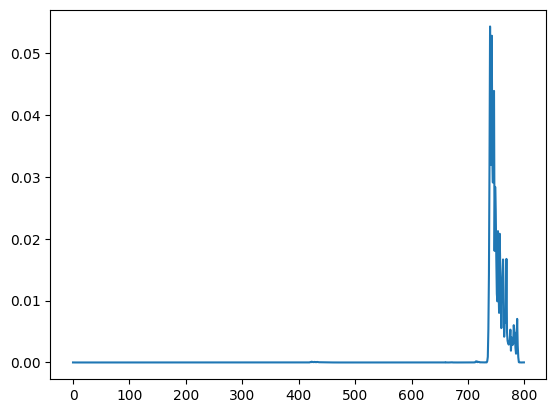

In [ ]:
#Generate audio samples from text

import IPython
import torch

import numpy as np
import pydub
import matplotlib.pyplot as plt
# from scipy.io.wavfile import write

def write_mp3(
  x,
  f="audio.mp3",
  sr=hp.sr,
  normalized=True
):
  """numpy array to MP3"""
  channels = 2 if (x.ndim == 2 and x.shape[1] == 2) else 1
  if normalized:  # normalized array - each item should be a float in [-1, 1)
      y = np.int16(x * 2 ** 15)
  else:
      y = np.int16(x)
  song = pydub.AudioSegment(y.tobytes(), frame_rate=sr, sample_width=2, channels=channels)
  song.export(f, format="mp3", bitrate="320k")

# Load the model state dictionary directly as it was saved without a wrapping dictionary
model = TransformerTTS().cuda()
model_state_dict = torch.load("model.pt")
model.load_state_dict(model_state_dict)

text = "I am a student of the Department of Applied Data Science at San Jose State University.\
 Currently I am studying artificial intelligence."

name_file = "gen_sample_neutral.mp3"

postnet_mel, gate = model.inference(
    text_to_seq(text).unsqueeze(0).cuda(),
    emotion_id=EMOTION_MAP["neutral"],   # or "angry", "sad", "surprise"
    stop_token_threshold=0.5,
    with_tqdm=False
)

audio = inverse_mel_spec_to_wav(postnet_mel.detach()[0].T)

plt.plot(
    torch.sigmoid(gate[0, :]).detach().cpu().numpy()
)

write_mp3(
    audio.detach().cpu().numpy(),
    name_file
)

IPython.display.Audio(
    audio.detach().cpu().numpy(),
    rate=hp.sr
)

/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


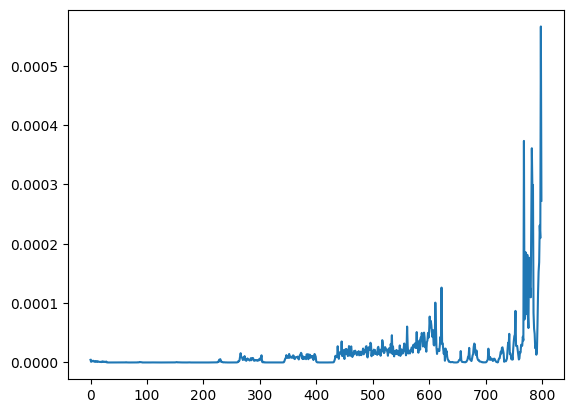

In [ ]:
text = "I hate that the job market is so bad right now!!"
name_file = "gen_sample_angry2.mp3"

postnet_mel, gate = model.inference(
    text_to_seq(text).unsqueeze(0).cuda(),
    emotion_id=EMOTION_MAP["angry"],   # or "angry", "sad", "surprise"
    stop_token_threshold=0.5,
    with_tqdm=False
)

audio = inverse_mel_spec_to_wav(postnet_mel.detach()[0].T)

plt.plot(
    torch.sigmoid(gate[0, :]).detach().cpu().numpy()
)

write_mp3(
    audio.detach().cpu().numpy(),
    name_file
)

IPython.display.Audio(
    audio.detach().cpu().numpy(),
    rate=hp.sr
)

/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


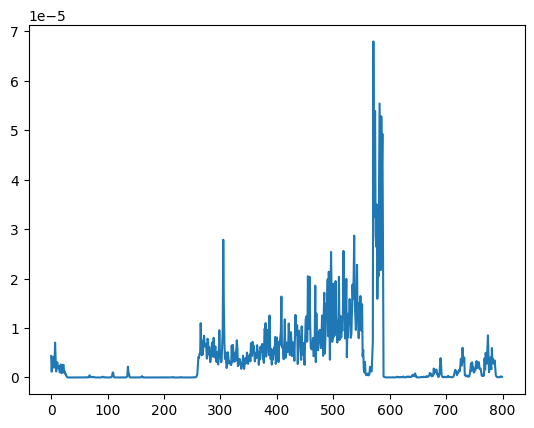

In [ ]:
text = "Yaay I am so happy that my exams are almost over.."
name_file = "gen_sample_happy.mp3"

postnet_mel, gate = model.inference(
    text_to_seq(text).unsqueeze(0).cuda(),
    emotion_id=EMOTION_MAP["happy"],   # or "angry", "sad", "surprise"
    stop_token_threshold=0.5,
    with_tqdm=False
)

audio = inverse_mel_spec_to_wav(postnet_mel.detach()[0].T)

plt.plot(
    torch.sigmoid(gate[0, :]).detach().cpu().numpy()
)

write_mp3(
    audio.detach().cpu().numpy(),
    name_file
)

IPython.display.Audio(
    audio.detach().cpu().numpy(),
    rate=hp.sr
)

/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


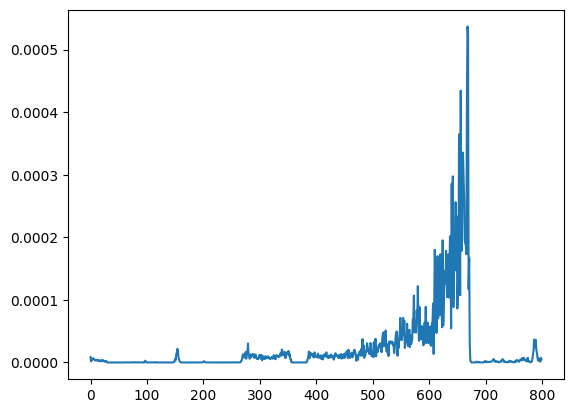

In [ ]:
text = "Oh no my text to speech model is not working well."
name_file = "gen_sample_sad.mp3"

postnet_mel, gate = model.inference(
    text_to_seq(text).unsqueeze(0).cuda(),
    emotion_id=EMOTION_MAP["sad"],   # or "angry", "sad", "surprise"
    stop_token_threshold=0.5,
    with_tqdm=False
)

audio = inverse_mel_spec_to_wav(postnet_mel.detach()[0].T)

plt.plot(
    torch.sigmoid(gate[0, :]).detach().cpu().numpy()
)

write_mp3(
    audio.detach().cpu().numpy(),
    name_file
)

IPython.display.Audio(
    audio.detach().cpu().numpy(),
    rate=hp.sr
)

/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


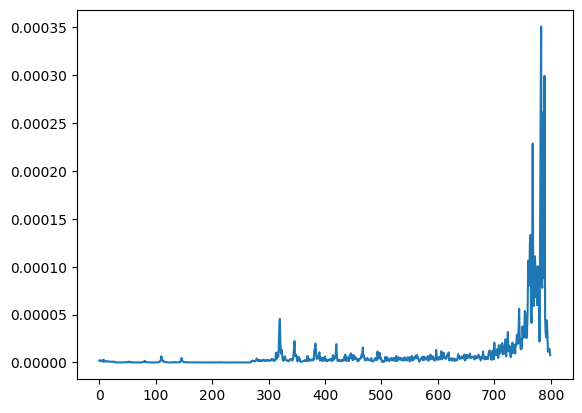

In [ ]:
text = "Oh my god what a pleasant surprise!"
name_file = "gen_sample_surprise2.mp3"

postnet_mel, gate = model.inference(
    text_to_seq(text).unsqueeze(0).cuda(),
    emotion_id=EMOTION_MAP["surprise"],   # or "angry", "sad", "surprise"
    stop_token_threshold=0.5,
    with_tqdm=False
)

audio = inverse_mel_spec_to_wav(postnet_mel.detach()[0].T)

plt.plot(
    torch.sigmoid(gate[0, :]).detach().cpu().numpy()
)

write_mp3(
    audio.detach().cpu().numpy(),
    name_file
)

IPython.display.Audio(
    audio.detach().cpu().numpy(),
    rate=hp.sr
)

# **Evaluation Cells**

In [ ]:
import subprocess
import sys

core_packages = [
    'transformers',
    'librosa',
    'jiwer',
    'torchaudio',
    'pydub'
]

optional_packages = ['pyworld', 'speechbrain']

print("Installing core packages...")
for package in core_packages:
    try:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', package])
        print(f"   {package}")
    except:
        print(f"   {package} failed")

print("\nInstalling optional packages...")
PYWORLD_AVAILABLE = False
SPEECHBRAIN_AVAILABLE = False

# Try pyworld
try:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', 'pyworld'])
    PYWORLD_AVAILABLE = True
    print("   pyworld (for advanced F0 extraction)")
except:
    print("   pyworld not available (will use librosa for F0)")
    PYWORLD_AVAILABLE = False

# Try speechbrain
try:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', 'speechbrain'])
    SPEECHBRAIN_AVAILABLE = True
    print("   speechbrain (for speaker verification)")
except:
    print("   speechbrain not available (speaker similarity will be skipped)")
    SPEECHBRAIN_AVAILABLE = False

print(f"\n Installation complete")
print(f"  PyWorld available: {PYWORLD_AVAILABLE}")
print(f"  SpeechBrain available: {SPEECHBRAIN_AVAILABLE}")

Installing core packages...


   transformers


   librosa


   jiwer


   torchaudio


   pydub

Installing optional packages...


  error: subprocess-exited-with-error
  
  × Building wheel for pyworld (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [13 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build/lib.linux-x86_64-cpython-310/pyworld
      copying pyworld/__init__.py -> build/lib.linux-x86_64-cpython-310/pyworld
      running build_ext
      Compiling pyworld/pyworld.pyx because it changed.
      [1/1] Cythonizing pyworld/pyworld.pyx
      building 'pyworld.pyworld' extension
      creating build/temp.linux-x86_64-cpython-310/lib/World/src
      creating build/temp.linux-x86_64-cpython-310/pyworld
      g++ -pthread -B /opt/conda/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /opt/conda/include -fPIC -O2 -isystem /opt/conda/include -fPIC -Ilib/World/src -I/tmp/pip-build-env-0wp7jj3v/overlay/lib/python3.10/site-packages/numpy/_core/include -I/opt/conda/include/python3.10 -c lib/World/src

   pyworld not available (will use librosa for F0)
   speechbrain (for speaker verification)

 Installation complete
  PyWorld available: False
  SpeechBrain available: True


In [ ]:
# Fix transformers version compatibility
import subprocess
import sys

print("Upgrading transformers to fix compatibility...")
subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', '--upgrade', 'transformers'])
print(" Transformers upgraded")

Upgrading transformers to fix compatibility...
 Transformers upgraded


In [ ]:
# Install OpenAI's whisper (no transformers dependency)
import subprocess
import sys

print("Installing OpenAI Whisper...")
subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', 'openai-whisper'])
print(" OpenAI Whisper installed")

Installing OpenAI Whisper...
 OpenAI Whisper installed


In [ ]:


audio_files = {
    'gen_sample_angry2.mp3': {
        'emotion': 'angry',
        'reference_text': 'I hate that the job market is so bad right now!!',
        'path': 'gen_sample_angry2.mp3'
    },
    'gen_sample_happy.mp3': {
        'emotion': 'happy',
        'reference_text': 'Yaay I am so happy that my exams are almost over. I will go for a vacation soon.',
        'path': 'gen_sample_happy.mp3'
    },
    'gen_sample_neutral.mp3': {
        'emotion': 'neutral',
        'reference_text': 'I am a student of the Department of Applied Data Science at San Jose State University. Currently I am studying artificial intelligence.',
        'path': 'gen_sample_neutral.mp3'
    },
    'gen_sample_sad.mp3': {
        'emotion': 'sad',
        'reference_text': 'Oh no my text to speech model is not working well.',
        'path': 'gen_sample_sad.mp3'
    },
    'gen_sample_surprise2.mp3': {
        'emotion': 'surprise',
        'reference_text': 'Oh my god what a pleasant surprise!',
        'path': 'gen_sample_surprise2.mp3'
    }
}

print(" Audio files configured")
print(f"Number of files to evaluate: {len(audio_files)}")

 Audio files configured
Number of files to evaluate: 5


In [ ]:
# Load ASR model using OpenAI Whisper

import whisper

print("Loading Whisper ASR model...")
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load model
model_size = "base"  # Options: tiny, base, small, medium, large
asr_model = whisper.load_model(model_size, device=device)

print(f" Whisper model loaded (size: {model_size}, device: {device})")

Loading Whisper ASR model...


100%|███████████████████████████████████████| 139M/139M [00:10<00:00, 13.8MiB/s]


 Whisper model loaded (size: base, device: cuda)


In [ ]:
# Compute WER and CER using OpenAI Whisper

def transcribe_audio_whisper(audio_path, model):
    """Transcribe audio using OpenAI Whisper"""
    # Transcribe
    result = model.transcribe(audio_path, fp16=(torch.cuda.is_available()))

    return result["text"].strip().lower()

def compute_intelligibility_metrics(audio_files, asr_model):
    """Compute WER and CER for all audio files"""
    results = []

    for filename, info in audio_files.items():
        print(f"\nProcessing: {filename}")

        # Transcribe
        hypothesis = transcribe_audio_whisper(info['path'], asr_model)
        reference = info['reference_text'].lower()

        # Compute metrics
        wer_score = wer(reference, hypothesis) * 100
        cer_score = cer(reference, hypothesis) * 100

        results.append({
            'file': filename,
            'emotion': info['emotion'],
            'reference': reference,
            'hypothesis': hypothesis,
            'WER (%)': round(wer_score, 2),
            'CER (%)': round(cer_score, 2)
        })

        print(f"  Reference:  {reference}")
        print(f"  Hypothesis: {hypothesis}")
        print(f"  WER: {wer_score:.2f}%, CER: {cer_score:.2f}%")

    return pd.DataFrame(results)

# Compute intelligibility metrics
print("Computing intelligibility metrics...")
intelligibility_df = compute_intelligibility_metrics(audio_files, asr_model)

print("\n" + "="*80)
print("INTELLIGIBILITY EVALUATION RESULTS (WER & CER)")
print("="*80)
print(intelligibility_df[['file', 'emotion', 'WER (%)', 'CER (%)']].to_string(index=False))
print(f"\nAverage WER: {intelligibility_df['WER (%)'].mean():.2f}%")
print(f"Average CER: {intelligibility_df['CER (%)'].mean():.2f}%")

Computing intelligibility metrics...

Processing: gen_sample_angry2.mp3
  Reference:  i hate that the job market is so bad right now!!
  Hypothesis: i hate that the job market is so bad right now. now. now. hey, hey, hey, hey, hey.
  WER: 72.73%, CER: 75.00%

Processing: gen_sample_happy.mp3
  Reference:  yaay i am so happy that my exams are almost over. i will go for a vacation soon.
  Hypothesis: yeah, i am so happy that my mind's all over
  WER: 66.67%, CER: 58.75%

Processing: gen_sample_neutral.mp3
  Reference:  i am a student of the department of applied data science at san jose state university. currently i am studying artificial intelligence.
  Hypothesis: i am a student of the department of applied data science at san jose, at san jose. currently, i am studying artificial intelligence.
  WER: 22.73%, CER: 10.37%

Processing: gen_sample_sad.mp3
  Reference:  oh no my text to speech model is not working well.
  Hypothesis: oh no, my test piece model is not working well. well
  W

In [ ]:
# Load speaker verification model and compute similarity

from speechbrain.pretrained import EncoderClassifier

print("Loading speaker verification model (ECAPA-TDNN)...")
speaker_model = EncoderClassifier.from_hparams(
    source="speechbrain/spkrec-ecapa-voxceleb",
    savedir="tmpdir_speaker"
)
print(" Speaker model loaded")

def compute_speaker_embedding(audio_path, model):
    """Extract speaker embedding from audio"""
    # Load audio
    signal, sr = torchaudio.load(audio_path)

    # Resample if needed
    if sr != 16000:
        resampler = torchaudio.transforms.Resample(sr, 16000)
        signal = resampler(signal)

    # Extract embedding
    with torch.no_grad():
        embedding = model.encode_batch(signal)

    return embedding

def compute_speaker_similarity(emb1, emb2):
    """Compute cosine similarity between two embeddings"""
    from torch.nn.functional import cosine_similarity

    # Flatten embeddings to 1D if needed
    emb1_flat = emb1.squeeze()
    emb2_flat = emb2.squeeze()

    # Compute similarity
    sim = cosine_similarity(emb1_flat, emb2_flat, dim=0)

    return sim.item()

print("Computing speaker embeddings...")
embeddings = {}
for filename, info in audio_files.items():
    embeddings[filename] = compute_speaker_embedding(info['path'], speaker_model)
    print(f"   {filename}")

# Compute pairwise similarities
print("\n" + "="*80)
print("SPEAKER EMBEDDING SIMILARITY MATRIX")
print("="*80)
print("Note: Without reference audio, showing inter-sample similarities")
print("In proper evaluation, compare against ground-truth speaker recordings\n")

files = list(audio_files.keys())
sim_matrix = np.zeros((len(files), len(files)))

for i, file1 in enumerate(files):
    for j, file2 in enumerate(files):
        sim_matrix[i, j] = compute_speaker_similarity(
            embeddings[file1], embeddings[file2]
        )

sim_df = pd.DataFrame(sim_matrix,
                      index=[audio_files[f]['emotion'] for f in files],
                      columns=[audio_files[f]['emotion'] for f in files])
print(sim_df.round(4))

print("\n" + "="*80)
print("SPEAKER CONSISTENCY ANALYSIS")
print("="*80)
# Check if all samples are from same speaker (high similarity expected)
off_diagonal = sim_matrix[np.triu_indices_from(sim_matrix, k=1)]
print(f"Average inter-sample similarity: {off_diagonal.mean():.4f}")
print(f"Min similarity: {off_diagonal.min():.4f}")
print(f"Max similarity: {off_diagonal.max():.4f}")
print(f"\nInterpretation:")
if off_diagonal.mean() > 0.8:
    print("   High consistency - All samples likely from same speaker")
elif off_diagonal.mean() > 0.6:
    print("   Moderate consistency - Some speaker variation detected")
else:
    print("   Low consistency - Significant speaker variation or quality issues")

Loading speaker verification model (ECAPA-TDNN)...
 Speaker model loaded
Computing speaker embeddings...
   gen_sample_angry2.mp3
   gen_sample_happy.mp3
   gen_sample_neutral.mp3
   gen_sample_sad.mp3
   gen_sample_surprise2.mp3

SPEAKER EMBEDDING SIMILARITY MATRIX
Note: Without reference audio, showing inter-sample similarities
In proper evaluation, compare against ground-truth speaker recordings

           angry   happy  neutral     sad  surprise
angry     1.0000  0.6660   0.2953  0.6165    0.5580
happy     0.6660  1.0000   0.3083  0.6132    0.4185
neutral   0.2953  0.3083   1.0000  0.2032    0.1816
sad       0.6165  0.6132   0.2032  1.0000    0.5034
surprise  0.5580  0.4185   0.1816  0.5034    1.0000

SPEAKER CONSISTENCY ANALYSIS
Average inter-sample similarity: 0.4364
Min similarity: 0.1816
Max similarity: 0.6660

Interpretation:
   Low consistency - Significant speaker variation or quality issues


In [ ]:
# Compute basic audio quality metrics

def compute_basic_quality_metrics(audio_files):
    """Compute basic audio quality metrics"""
    results = []

    for filename, info in audio_files.items():
        # Load audio
        audio, sr = librosa.load(info['path'], sr=None)

        # Duration
        duration = len(audio) / sr

        # RMS (Root Mean Square) - loudness/energy
        rms = np.sqrt(np.mean(audio**2))

        # Peak amplitude
        peak = np.max(np.abs(audio))

        # Zero crossing rate (speech naturalness indicator)
        zcr = np.mean(librosa.feature.zero_crossing_rate(audio))

        # Spectral centroid (brightness of sound)
        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sr))

        results.append({
            'file': filename,
            'emotion': info['emotion'],
            'duration (s)': round(duration, 2),
            'RMS': round(rms, 4),
            'Peak': round(peak, 4),
            'ZCR': round(zcr, 4),
            'Spectral Centroid (Hz)': round(spectral_centroid, 2)
        })

    return pd.DataFrame(results)

quality_df = compute_basic_quality_metrics(audio_files)

print("="*80)
print("AUDIO QUALITY METRICS")
print("="*80)
print(quality_df.to_string(index=False))
print(f"\nAverage Duration: {quality_df['duration (s)'].mean():.2f}s")
print(f"Average RMS: {quality_df['RMS'].mean():.4f}")
print(f"Average Peak: {quality_df['Peak'].mean():.4f}")

AUDIO QUALITY METRICS
                    file  emotion  duration (s)    RMS   Peak    ZCR  Spectral Centroid (Hz)
   gen_sample_angry2.mp3    angry          9.28 0.0055 0.0705 0.0786                 1650.51
    gen_sample_happy.mp3    happy          9.28 0.0071 0.0736 0.1120                 1919.23
  gen_sample_neutral.mp3  neutral          9.28 0.0112 0.1048 0.1837                 2763.81
      gen_sample_sad.mp3      sad          9.28 0.0052 0.0566 0.0974                 1524.24
gen_sample_surprise2.mp3 surprise          9.28 0.0042 0.0550 0.0606                 1594.72

Average Duration: 9.28s
Average RMS: 0.0066
Average Peak: 0.0721


In [ ]:
# Prosody Evaluation: F0 (Pitch) Analysis using librosa

def extract_f0_statistics(audio_path):
    """Extract F0 (pitch) statistics from audio using librosa"""
    # Load audio
    audio, sr = librosa.load(audio_path, sr=None)

    # Extract F0 using librosa's piptrack
    pitches, magnitudes = librosa.piptrack(y=audio, sr=sr, fmin=50, fmax=500)

    # Get the pitch with highest magnitude at each frame
    f0 = []
    for t in range(pitches.shape[1]):
        index = magnitudes[:, t].argmax()
        pitch = pitches[index, t]
        if pitch > 0:  # Only voiced frames
            f0.append(pitch)

    f0 = np.array(f0)

    if len(f0) == 0:
        return None

    return {
        'mean_f0': np.mean(f0),
        'std_f0': np.std(f0),
        'min_f0': np.min(f0),
        'max_f0': np.max(f0),
        'f0_range': np.max(f0) - np.min(f0)
    }

def compute_prosody_metrics(audio_files):
    """Compute prosody metrics for all audio files"""
    results = []

    for filename, info in audio_files.items():
        print(f"Extracting F0 from: {filename}")
        f0_stats = extract_f0_statistics(info['path'])

        if f0_stats is not None:
            results.append({
                'file': filename,
                'emotion': info['emotion'],
                'Mean F0 (Hz)': round(f0_stats['mean_f0'], 2),
                'Std F0 (Hz)': round(f0_stats['std_f0'], 2),
                'Min F0 (Hz)': round(f0_stats['min_f0'], 2),
                'Max F0 (Hz)': round(f0_stats['max_f0'], 2),
                'F0 Range (Hz)': round(f0_stats['f0_range'], 2)
            })

    return pd.DataFrame(results)

prosody_df = compute_prosody_metrics(audio_files)

print("="*80)
print("PROSODY METRICS (F0 Analysis)")
print("="*80)
print(prosody_df.to_string(index=False))
print(f"\nAverage Mean F0: {prosody_df['Mean F0 (Hz)'].mean():.2f} Hz")
print(f"Average F0 Range: {prosody_df['F0 Range (Hz)'].mean():.2f} Hz")

Extracting F0 from: gen_sample_angry2.mp3
Extracting F0 from: gen_sample_happy.mp3
Extracting F0 from: gen_sample_neutral.mp3
Extracting F0 from: gen_sample_sad.mp3
Extracting F0 from: gen_sample_surprise2.mp3
PROSODY METRICS (F0 Analysis)
                    file  emotion  Mean F0 (Hz)  Std F0 (Hz)  Min F0 (Hz)  Max F0 (Hz)  F0 Range (Hz)
   gen_sample_angry2.mp3    angry    202.559998   104.800003    49.549999   490.329987     440.779999
    gen_sample_happy.mp3    happy    233.919998   125.800003    50.009998   500.350006     450.350006
  gen_sample_neutral.mp3  neutral    327.950012    86.870003   158.779999   498.690002     339.899994
      gen_sample_sad.mp3      sad    314.600006    68.010002    63.849998   486.929993     423.079987
gen_sample_surprise2.mp3 surprise    233.639999   151.300003    48.740002   498.589996     449.850006

Average Mean F0: 262.53 Hz
Average F0 Range: 420.79 Hz


In [ ]:
# Merge all results into comprehensive evaluation report

final_results = intelligibility_df[['file', 'emotion', 'WER (%)', 'CER (%)']].copy()
final_results = final_results.merge(
    quality_df[['file', 'duration (s)', 'RMS', 'Peak']],
    on='file'
)
final_results = final_results.merge(
    prosody_df[['file', 'Mean F0 (Hz)', 'F0 Range (Hz)']],
    on='file'
)

print("="*100)
print("COMPREHENSIVE TTS EVALUATION REPORT")
print("Based on: 'Towards Responsible Evaluation for Text-to-Speech' (Yang et al., 2025)")
print("="*100)
print("\n" + final_results.to_string(index=False))

print("\n" + "="*100)
print("OVERALL STATISTICS")
print("="*100)
print(f"Average WER: {final_results['WER (%)'].mean():.2f}% (Lower is better)")
print(f"Average CER: {final_results['CER (%)'].mean():.2f}% (Lower is better)")
print(f"Average Duration: {final_results['duration (s)'].mean():.2f}s")
print(f"Average RMS: {final_results['RMS'].mean():.4f}")
print(f"Average Peak: {final_results['Peak'].mean():.4f}")
print(f"Average F0: {final_results['Mean F0 (Hz)'].mean():.2f} Hz")

print("\n" + "="*100)
print("EVALUATION BY EMOTION")
print("="*100)
emotion_summary = final_results.groupby('emotion').agg({
    'WER (%)': 'mean',
    'CER (%)': 'mean',
    'RMS': 'mean',
    'Mean F0 (Hz)': 'mean'
}).round(2)
print(emotion_summary)

# Save results
final_results.to_csv('tts_evaluation_results.csv', index=False)
print("\n Results saved to: tts_evaluation_results.csv")

COMPREHENSIVE TTS EVALUATION REPORT
Based on: 'Towards Responsible Evaluation for Text-to-Speech' (Yang et al., 2025)

                    file  emotion  WER (%)  CER (%)  duration (s)    RMS   Peak  Mean F0 (Hz)  F0 Range (Hz)
   gen_sample_angry2.mp3    angry    72.73    75.00          9.28 0.0055 0.0705    202.559998     440.779999
    gen_sample_happy.mp3    happy    66.67    58.75          9.28 0.0071 0.0736    233.919998     450.350006
  gen_sample_neutral.mp3  neutral    22.73    10.37          9.28 0.0112 0.1048    327.950012     339.899994
      gen_sample_sad.mp3      sad    45.45    26.00          9.28 0.0052 0.0566    314.600006     423.079987
gen_sample_surprise2.mp3 surprise    42.86    14.29          9.28 0.0042 0.0550    233.639999     449.850006

OVERALL STATISTICS
Average WER: 50.09% (Lower is better)
Average CER: 36.88% (Lower is better)
Average Duration: 9.28s
Average RMS: 0.0066
Average Peak: 0.0721
Average F0: 262.53 Hz

EVALUATION BY EMOTION
          WER (%)  CE

Generating mel-spectrograms...

Processing: gen_sample_angry2.mp3 (Angry)
   Saved: mel_spectrograms/angry_melspec.png


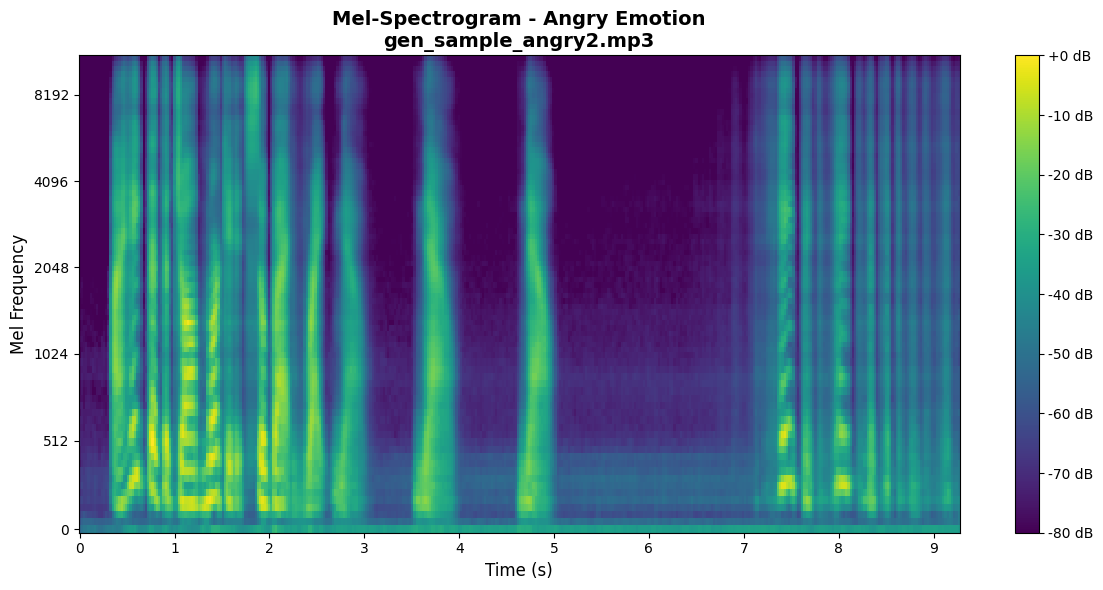


Processing: gen_sample_happy.mp3 (Happy)
   Saved: mel_spectrograms/happy_melspec.png


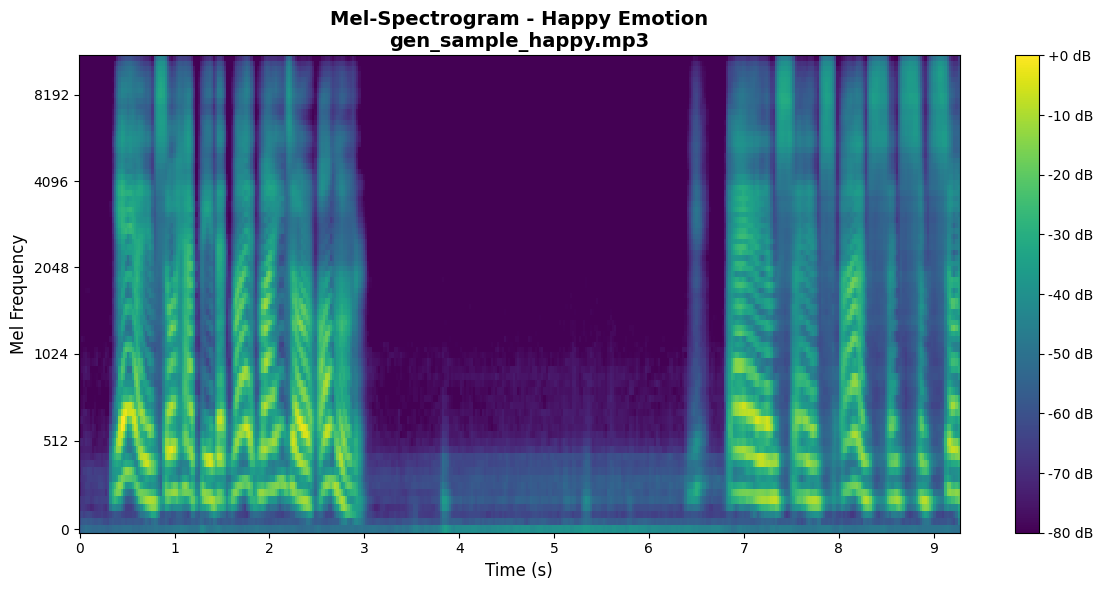


Processing: gen_sample_neutral.mp3 (Neutral)
   Saved: mel_spectrograms/neutral_melspec.png


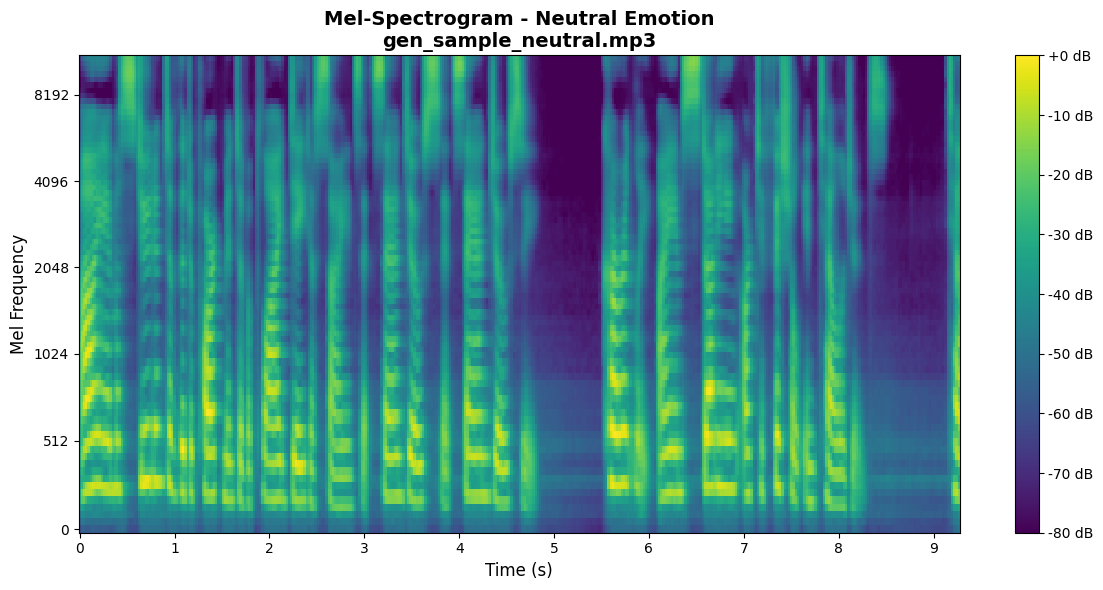


Processing: gen_sample_sad.mp3 (Sad)
   Saved: mel_spectrograms/sad_melspec.png


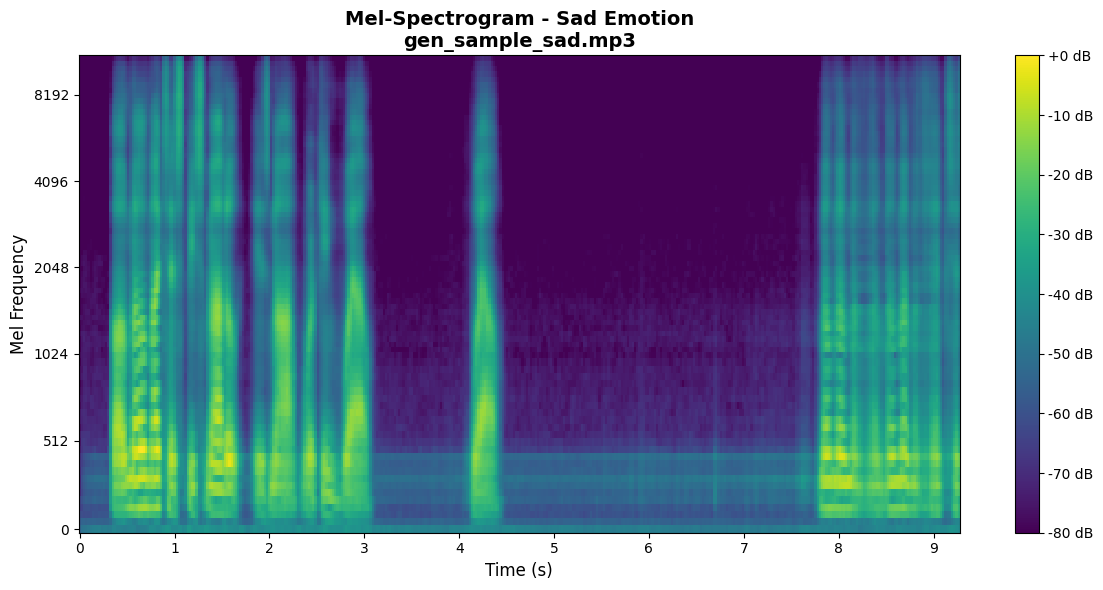


Processing: gen_sample_surprise2.mp3 (Surprise)
   Saved: mel_spectrograms/surprise_melspec.png


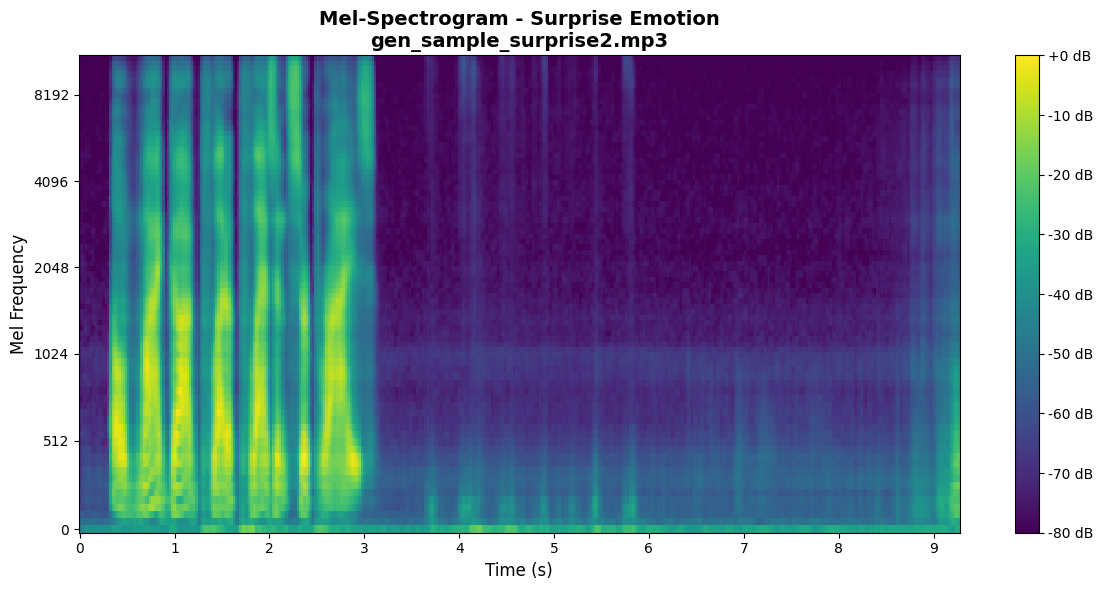


 All mel-spectrograms generated and saved to 'mel_spectrograms/' folder


In [ ]:
# Generate and visualize mel-spectrograms for TTS evaluation

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os

# Create output directory
os.makedirs('mel_spectrograms', exist_ok=True)

# Audio files
audio_files = {
    'gen_sample_angry2.mp3': 'Angry',
    'gen_sample_happy.mp3': 'Happy',
    'gen_sample_neutral.mp3': 'Neutral',
    'gen_sample_sad.mp3': 'Sad',
    'gen_sample_surprise2.mp3': 'Surprise'
}

# Mel-spectrogram parameters (matching your model's hp)
sr = 22050  # Sample rate
n_fft = 2048
hop_length = 512
n_mels = 80

print("Generating mel-spectrograms...")
print("="*70)

for filename, emotion in audio_files.items():
    print(f"\nProcessing: {filename} ({emotion})")

    # Load audio
    audio, _ = librosa.load(filename, sr=sr)

    # Generate mel-spectrogram
    mel_spec = librosa.feature.melspectrogram(
        y=audio,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
        fmin=0,
        fmax=8000
    )

    # Convert to dB scale
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    # Create figure
    plt.figure(figsize=(12, 6))

    # Plot mel-spectrogram
    img = librosa.display.specshow(
        mel_spec_db,
        sr=sr,
        hop_length=hop_length,
        x_axis='time',
        y_axis='mel',
        cmap='viridis'
    )

    plt.colorbar(img, format='%+2.0f dB')
    plt.title(f'Mel-Spectrogram - {emotion} Emotion\n{filename}', fontsize=14, fontweight='bold')
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('Mel Frequency', fontsize=12)
    plt.tight_layout()

    # Save
    output_path = f'mel_spectrograms/{emotion.lower()}_melspec.png'
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    print(f"   Saved: {output_path}")

    plt.show()
    plt.close()

print("\n" + "="*70)
print(" All mel-spectrograms generated and saved to 'mel_spectrograms/' folder")

 Comparison grid saved: mel_spectrograms/all_emotions_comparison.png


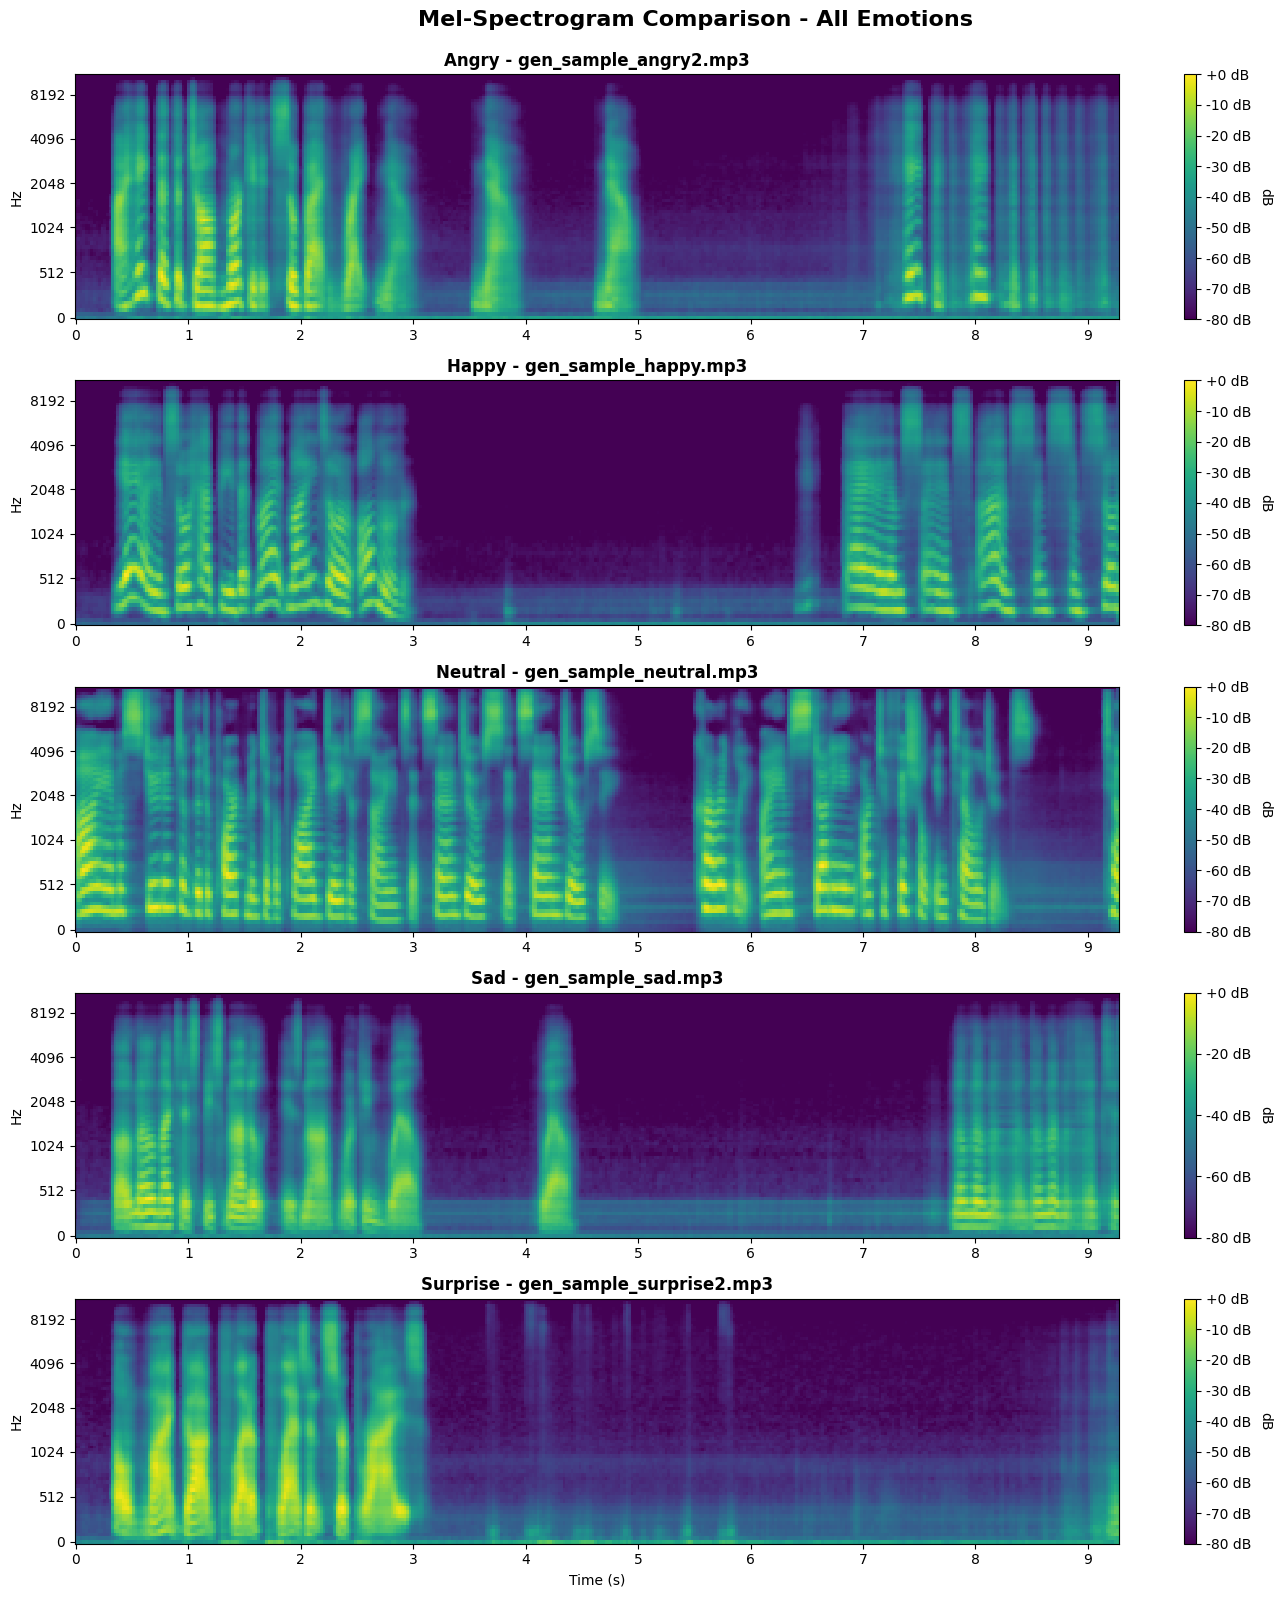

In [ ]:
# Create comparison grid of all mel-spectrograms

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Parameters
sr = 22050
n_fft = 2048
hop_length = 512
n_mels = 80

# Audio files
audio_files = [
    ('gen_sample_angry2.mp3', 'Angry'),
    ('gen_sample_happy.mp3', 'Happy'),
    ('gen_sample_neutral.mp3', 'Neutral'),
    ('gen_sample_sad.mp3', 'Sad'),
    ('gen_sample_surprise2.mp3', 'Surprise')
]

# Create figure with subplots
fig, axes = plt.subplots(5, 1, figsize=(14, 16))
fig.suptitle('Mel-Spectrogram Comparison - All Emotions', fontsize=16, fontweight='bold', y=0.995)

for idx, (filename, emotion) in enumerate(audio_files):
    # Load audio
    audio, _ = librosa.load(filename, sr=sr)

    # Generate mel-spectrogram
    mel_spec = librosa.feature.melspectrogram(
        y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels
    )
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    # Plot
    img = librosa.display.specshow(
        mel_spec_db,
        sr=sr,
        hop_length=hop_length,
        x_axis='time',
        y_axis='mel',
        ax=axes[idx],
        cmap='viridis'
    )

    axes[idx].set_title(f'{emotion} - {filename}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Time (s)' if idx == 4 else '')

    # Add colorbar
    cbar = plt.colorbar(img, ax=axes[idx], format='%+2.0f dB')
    cbar.set_label('dB', rotation=270, labelpad=15)

plt.tight_layout()
plt.savefig('mel_spectrograms/all_emotions_comparison.png', dpi=150, bbox_inches='tight')
print(" Comparison grid saved: mel_spectrograms/all_emotions_comparison.png")
plt.show()